# A Comparative Study of Imputation Methods for Predicting Financial Health:Impact on Machine Learning Model Performance

## Importing Essential Packages

In [3]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
import xgboost as xgb

import lightgbm as lgb
from lightgbm import LGBMClassifier

import catboost
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [5]:
# Load the datasets
companies = pd.read_csv('/Users/shraddha/Desktop/Dissertation/companies.csv')
companies_sic_codes = pd.read_csv('/Users/shraddha/Desktop/Dissertation/companies_sic_codes.csv')
filings = pd.read_csv('/Users/shraddha/Desktop/Dissertation/filings.csv')
officers_and_owners = pd.read_csv('/Users/shraddha/Desktop/Dissertation/officers_and_owners.csv')

In [6]:
print('comapnies',companies.shape)
print('companies_sic_codes',companies_sic_codes.shape)
print('filings',filings.shape)
print('officers_and_owners',officers_and_owners.shape)

comapnies (5428900, 18)
companies_sic_codes (7856665, 6)
filings (22535531, 5)
officers_and_owners (10519812, 12)


In [7]:
# Merging datasets for analysis
# Example: Merging companies with SIC codes
merged_data = pd.merge(companies_sic_codes, companies, on='company_number', how='left')
merged_data = pd.merge(merged_data, officers_and_owners, on='company_number', how='left')
merged_data = pd.merge(merged_data, filings, on='company_number', how='left')

In [8]:
# Check the structure and data types of the dataset
print(merged_data.info())  # This will show data types, non-null counts, and the shape of the dataset
print(merged_data.head())  # Display the first few rows of the dataset to understand the content

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37280014 entries, 0 to 37280013
Data columns (total 38 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   company_number                          object 
 1   sic_code                                int64  
 2   sic_description                         object 
 3   sic_section                             object 
 4   sic_division                            object 
 5   company_url_x                           object 
 6   company_type                            object 
 7   office_address                          object 
 8   incorporation_date                      object 
 9   jurisdiction                            object 
 10  company_status                          object 
 11  account_type                            object 
 12  company_name                            object 
 13  sic_codes                               object 
 14  date_of_cessation               

# Data Pre-Processing

In [10]:
# 1. Downcast Numeric Columns
# Downcast 'float64' columns to 'float32' or 'float16' where appropriate
merged_data['pages'] = pd.to_numeric(merged_data['pages'], downcast='float')
merged_data['person_id'] = pd.to_numeric(merged_data['person_id'], downcast='float')
merged_data['owners'] = pd.to_numeric(merged_data['owners'], downcast='float')
merged_data['officers'] = pd.to_numeric(merged_data['officers'], downcast='float')
merged_data['average_number_employees_during_period'] = pd.to_numeric(merged_data['average_number_employees_during_period'], downcast='float')
merged_data['current_assets'] = pd.to_numeric(merged_data['current_assets'], downcast='float')

# Downcast 'int64' columns to 'int32' or 'int16' if the values fit
merged_data['sic_code'] = pd.to_numeric(merged_data['sic_code'], downcast='integer')
merged_data['person_id'] = pd.to_numeric(merged_data['person_id'], downcast='integer')

# 2. Convert object columns with repeated values to category dtype (especially columns with lots of repetitive text)
categorical_columns = ['company_number', 'sic_description', 'sic_section', 'sic_division', 'company_url_x', 'category',
                       'description', 'name', 'kind', 'officer_role', 'occupation', 'country_of_residence', 
                       'nationality', 'company_country', 'company_type', 'office_address', 'jurisdiction', 
                       'company_status', 'account_type', 'company_name', 'sic_codes', 'date_of_cessation', 
                       'next_accounts_overdue', 'confirmation_statement_overdue', 'company_url_y','is_owner','person_url']
                       
for col in categorical_columns:
    merged_data[col] = merged_data[col].astype('category')

# 3. Convert date columns to datetime format to reduce memory usage (instead of keeping them as objects)
date_columns = ['date_x', 'date_y', 'incorporation_date', 'last_accounts_period_end', 'date_of_cessation']
for col in date_columns:
    merged_data[col] = pd.to_datetime(merged_data[col], errors='coerce')

In [11]:
# 5. Check the memory usage after optimization
print(merged_data.info())  # This will show the reduced memory usage

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37280014 entries, 0 to 37280013
Data columns (total 38 columns):
 #   Column                                  Dtype         
---  ------                                  -----         
 0   company_number                          category      
 1   sic_code                                int32         
 2   sic_description                         category      
 3   sic_section                             category      
 4   sic_division                            category      
 5   company_url_x                           category      
 6   company_type                            category      
 7   office_address                          category      
 8   incorporation_date                      datetime64[ns]
 9   jurisdiction                            category      
 10  company_status                          category      
 11  account_type                            category      
 12  company_name                            

In [12]:
# 2. Downcast 'float64' columns to 'float32' if they fit the range
merged_data['person_id'] = pd.to_numeric(merged_data['person_id'], downcast='float')
merged_data['average_number_employees_during_period'] = pd.to_numeric(merged_data['average_number_employees_during_period'], downcast='float')
merged_data['current_assets'] = pd.to_numeric(merged_data['current_assets'], downcast='float')


# 3. Optimize datetime columns: Converting to datetime with lower precision can save memory if microsecond precision is not needed.
# Convert to 'datetime64[ms]' if sub-second precision is not required
merged_data['date_x'] = merged_data['date_x'].dt.floor('ms')
merged_data['date_y'] = merged_data['date_y'].dt.floor('ms')
merged_data['incorporation_date'] = merged_data['incorporation_date'].dt.floor('ms')
merged_data['last_accounts_period_end'] = merged_data['last_accounts_period_end'].dt.floor('ms')

# 4. Check memory usage after optimization
print(merged_data.info())
print(f"Memory usage after further optimization: {merged_data.memory_usage(deep=True).sum() / (1024**2):.2f} MB")


<class 'pandas.core.frame.DataFrame'>
Int64Index: 37280014 entries, 0 to 37280013
Data columns (total 38 columns):
 #   Column                                  Dtype         
---  ------                                  -----         
 0   company_number                          category      
 1   sic_code                                int32         
 2   sic_description                         category      
 3   sic_section                             category      
 4   sic_division                            category      
 5   company_url_x                           category      
 6   company_type                            category      
 7   office_address                          category      
 8   incorporation_date                      datetime64[ns]
 9   jurisdiction                            category      
 10  company_status                          category      
 11  account_type                            category      
 12  company_name                            

In [13]:
# Check the percentage of missing values in each column
missing_percent_ = merged_data.isnull().mean() * 100
print(f"Missing values percentage in each column:\n{missing_percent_}")

Missing values percentage in each column:
company_number                             0.000000
sic_code                                   0.000000
sic_description                            0.000000
sic_section                                0.000000
sic_division                               0.000000
company_url_x                              0.000000
company_type                              46.164073
office_address                            46.172386
incorporation_date                        46.164073
jurisdiction                              46.167780
company_status                            46.164073
account_type                              46.778888
company_name                              46.164076
sic_codes                                 49.219319
date_of_cessation                         96.804264
next_accounts_overdue                     92.394928
confirmation_statement_overdue            92.165330
owners                                    50.142513
officers              

In [14]:
# --------------------------------------------
# Step 1: Drop Unnecessary Columns
# --------------------------------------------
columns_to_drop = ['name', 'kind', 'officer_role', 'is_owner', 'person_id', 'person_url','occupation',
                   'date_of_cessation', 'company_url_x','company_url_y','company_number', 'company_name', 'office_address',
                  'description','company_country','nationality','country_of_residence',
                   'sic_description','sic_division','date_y']

merged_data.drop(columns=columns_to_drop, inplace=True)

'''
We dropped columns with more than 50% missing values (e.g., name, kind, officer_role) or those that are unlikely to be useful for predicting financial health and growth.
'''

'\nWe dropped columns with more than 50% missing values (e.g., name, kind, officer_role) or those that are unlikely to be useful for predicting financial health and growth.\n'

In [15]:
# Check the percentage of missing values in each column
missing_percent = merged_data.isnull().mean() * 100
print(f"Missing values percentage in each column:\n{missing_percent}")

Missing values percentage in each column:
sic_code                                   0.000000
sic_section                                0.000000
company_type                              46.164073
incorporation_date                        46.164073
jurisdiction                              46.167780
company_status                            46.164073
account_type                              46.778888
sic_codes                                 49.219319
next_accounts_overdue                     92.394928
confirmation_statement_overdue            92.165330
owners                                    50.142513
officers                                  47.028333
average_number_employees_during_period    58.338100
current_assets                            64.107784
last_accounts_period_end                  51.238953
date_x                                    57.545341
category                                   2.989446
pages                                      2.989436
dtype: float64


# Year based Sampling

In [17]:
# Assuming merged_data is your original dataframe
# If 'year' is not a direct column, we can extract it from 'incorporation_date'
merged_data['year'] = merged_data['incorporation_date'].dt.year

# Step 1: Calculate the year-wise distribution for sampling
year_distribution = merged_data['year'].value_counts(normalize=True).sort_index()

# Step 2: Determine the number of records to sample from each year to get 500,000 records
target_sample_size = 50000
year_sample_counts = (year_distribution * target_sample_size).round().astype(int)

# Step 3: Initialize an empty DataFrame to store the sampled records
final_data = pd.DataFrame()

# Step 4: Sample records for each year based on calculated distribution
for year, count in year_sample_counts.items():
    # Filter records for the specific year
    year_records = merged_data[merged_data['year'] == year]
    year_sampled_records = year_records.sample(n=count, random_state=42)
    final_data = pd.concat([final_data, year_sampled_records], axis=0)

if final_data.shape[0] > target_sample_size:
    final_data = final_data.sample(n=target_sample_size, random_state=42)
elif final_data.shape[0] < target_sample_size:
    additional_samples_needed = target_sample_size - final_data.shape[0]
    additional_samples = merged_data.sample(n=additional_samples_needed, random_state=42)
    final_data = pd.concat([final_data, additional_samples], axis=0)

# Step 6: Reset index of the sampled data
final_data = final_data.reset_index(drop=True)

print(f"Final sampled data shape: {final_data.shape}")

Final sampled data shape: (50000, 19)


In [18]:
# Check the percentage of missing values in each column
missing_percent = final_data.isnull().mean() * 100
print(f"Missing values percentage in each column:\n{missing_percent}")

Missing values percentage in each column:
sic_code                                   0.000
sic_section                                0.000
company_type                               0.002
incorporation_date                         0.002
jurisdiction                               0.002
company_status                             0.002
account_type                               1.128
sic_codes                                  5.608
next_accounts_overdue                     85.772
confirmation_statement_overdue            85.338
owners                                     7.318
officers                                   1.562
average_number_employees_during_period    22.522
current_assets                            33.156
last_accounts_period_end                   9.392
date_x                                    48.456
category                                   0.216
pages                                      0.216
year                                       0.002
dtype: float64


## Missing Data Distribution

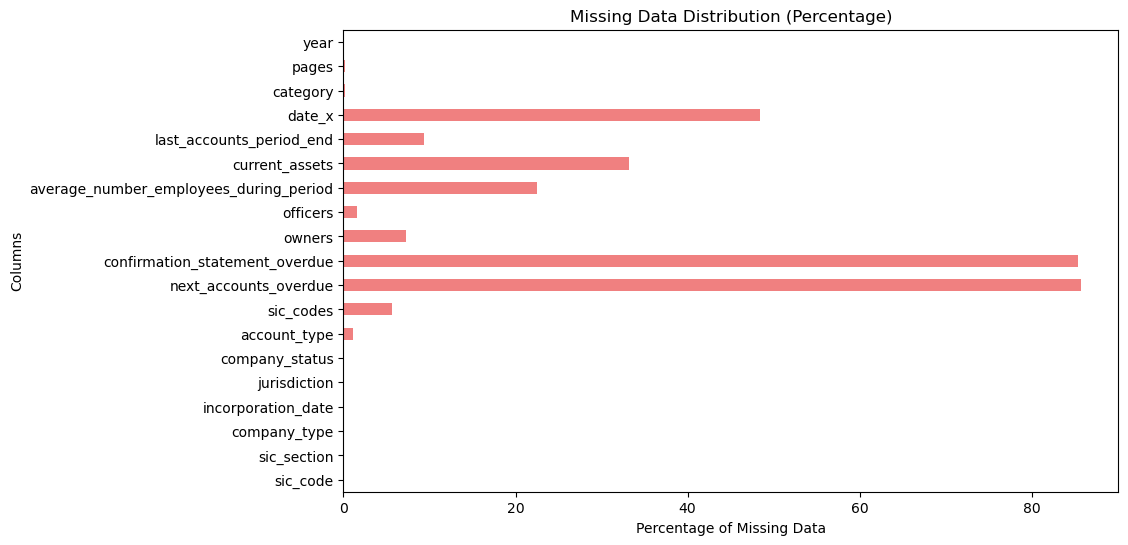

In [19]:
# Missing Data Bar Plot
plt.figure(figsize=(10, 6))
missing_percent.plot(kind='barh', color='lightcoral')
plt.title('Missing Data Distribution (Percentage)')
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Columns')
plt.show()

# Separate Numerical and Categorical Columns

In [21]:
print("Categories for 'next_accounts_overdue':", merged_data['next_accounts_overdue'].unique())
print("Categories for 'confirmation_statement_overdue':", merged_data['confirmation_statement_overdue'].unique())

Categories for 'next_accounts_overdue': [NaN, True, False]
Categories (2, bool): [False, True]
Categories for 'confirmation_statement_overdue': [NaN, True, False]
Categories (2, bool): [False, True]


In [24]:
# 1. Separate numerical and categorical columns
numerical_columns = final_data.select_dtypes(include=['float64', 'float32', 'int32', 'int64']).columns
categorical_columns = final_data.select_dtypes(include=['object', 'category']).columns

# Imputation for numerical columns and date columns

In [27]:
# 2. Create a SimpleImputer for Mean Imputation for numerical data
mean_imputer = SimpleImputer(strategy='mean')

# 3. Apply mean imputation on numerical columns
final_data[numerical_columns] = mean_imputer.fit_transform(final_data[numerical_columns])

# Impute missing date columns with a default date or forward fill
final_data['last_accounts_period_end'] = final_data['last_accounts_period_end'].fillna(pd.to_datetime('2000-01-01'))
final_data['incorporation_date'] = final_data['incorporation_date'].fillna(pd.to_datetime('2000-01-01'))

# For update-related columns like 'date_x' and 'date_y', forward fill makes sense
final_data['date_x'] = final_data['date_x'].fillna(method='ffill')

# Mode Imputation

In [39]:
# Impute missing categorical values with the mode (most frequent value)
final_data_mode_imputed = final_data.copy()

# Impute categorical columns with 'most_frequent' (mode)
for column in categorical_columns:
    final_data_mode_imputed[column] = final_data_mode_imputed[column].fillna(final_data_mode_imputed[column].mode()[0])

# Check if missing values are imputed
print(final_data_mode_imputed.isnull().sum())

final_data_mode_imputed['next_accounts_overdue'] = final_data_mode_imputed['next_accounts_overdue'].astype(int)
final_data_mode_imputed['confirmation_statement_overdue'] = final_data_mode_imputed['confirmation_statement_overdue'].astype(int)

sic_code                                  0
sic_section                               0
company_type                              0
incorporation_date                        0
jurisdiction                              0
company_status                            0
account_type                              0
sic_codes                                 0
next_accounts_overdue                     0
confirmation_statement_overdue            0
owners                                    0
officers                                  0
average_number_employees_during_period    0
current_assets                            0
last_accounts_period_end                  0
date_x                                    1
category                                  0
pages                                     0
year                                      0
dtype: int64


## Feature Engineering

In [41]:
# Calculate the 50th percentile (median) and 75th percentile for `current_assets`
assets_median = final_data_mode_imputed['current_assets'].median()
assets_75th_percentile = final_data_mode_imputed['current_assets'].quantile(0.75)

# Step 1: Create financial_health target variable based on `current_assets`
# Companies with assets greater than the 75th percentile are considered financially healthy
final_data_mode_imputed['financial_health'] = final_data_mode_imputed['current_assets'].apply(lambda x: 1 if x > assets_75th_percentile else 0)

# Check the first few rows to ensure the target variables are created correctly
print(final_data_mode_imputed[['financial_health']].head())

# Check the distribution of the target variables
print("\nClass distribution for financial health:")
print(final_data_mode_imputed['financial_health'].value_counts())

   financial_health
0                 0
1                 0
2                 0
3                 0
4                 0

Class distribution for financial health:
0    46168
1     3832
Name: financial_health, dtype: int64


In [42]:

# Step 2: Handle the year and month extraction
final_data_mode_imputed['year_founded'] = pd.to_datetime(final_data_mode_imputed['incorporation_date'], errors='coerce').dt.year
final_data_mode_imputed['month_founded'] = pd.to_datetime(final_data_mode_imputed['incorporation_date'], errors='coerce').dt.month
final_data_mode_imputed['year_last_updated'] = pd.to_datetime(final_data_mode_imputed['date_x'], errors='coerce').dt.year
final_data_mode_imputed['month_last_updated'] = pd.to_datetime(final_data_mode_imputed['date_x'], errors='coerce').dt.month

# Step 3: Create company age
final_data_mode_imputed['company_age'] = final_data_mode_imputed['year_last_updated'] - final_data_mode_imputed['year_founded']

# Step 4: Reduce the memory by downcasting the data types
final_data_mode_imputed['company_age'] = final_data_mode_imputed['company_age'].astype('float32')

# Step 5: Remove pct_change for large datasets to reduce memory usage
final_data_mode_imputed['asset_growth'] = final_data_mode_imputed['current_assets'].diff() / final_data_mode_imputed['current_assets'].shift(1)
#final_data_mode_imputed['employee_growth'] = final_data_mode_imputed['average_number_employees_during_period'].diff() / final_data_mode_imputed['average_number_employees_during_period'].shift(1)

# Step 7: Combine company size based on assets and employees
final_data_mode_imputed['company_size'] = final_data_mode_imputed['average_number_employees_during_period'] * final_data_mode_imputed['current_assets']

# Step 9: Reduce memory usage by converting columns to 'float32' where possible
final_data_mode_imputed['asset_growth'] = final_data_mode_imputed['asset_growth'].astype('float32')
final_data_mode_imputed['company_size'] = final_data_mode_imputed['company_size'].astype('float32')

print(f"Memory usage after optimization: {final_data_mode_imputed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Memory usage after optimization: 19.70 MB


In [43]:
# SIC Section Mapping
sic_mapping = {
    "Other service activities": "Other Services",
    "Information and communication": "Info & Communication",
    "Professional, scientific and technical activities": "Professional/Scientific",
    "Activities of households as employers; undifferentiated goods-and services-producing activities of households for own use": "Household Activities",
    "Real estate activities": "Real Estate",
    "Transportation and storage": "Transportation",
    "Construction": "Construction",
    "Arts, entertainment and recreation": "Arts & Entertainment",
    "Administrative and support service activities": "Admin Support",
    "None Supplied": "Unspecified",
    "Mining and quarrying": "Mining & Quarrying",
    "Manufacturing": "Manufacturing",
    "Accommodation and food service activities": "Accommodation & Food",
    "Agriculture, forestry and fishing": "Agriculture",
    "Wholesale and retail trade; repair of motor vehicles and motorcycles": "Wholesale & Retail",
    "Dormant company": "Dormant",
    "Education": "Education",
    "Financial and insurance activities": "Financial/Insurance",
    "Human health and social work activities": "Health & Social Work",
    "Electricity, gas, steam and air conditioning supply": "Utilities",
    "Water supply; sewerage, waste management and remediation activities": "Water & Waste",
    "Public administration and defence; compulsory social security": "Public Administration",
    "Activities of extraterritorial organisations and bodies": "Extraterritorial"
}

# Apply mapping
final_data_mode_imputed['sic_section_short'] = final_data_mode_imputed['sic_section'].map(sic_mapping)

In [44]:

# Combine SIC Code and Company Type (Industry Type)
final_data_mode_imputed['industry_company_type'] = final_data_mode_imputed['sic_codes'].astype(str) + "_" + final_data_mode_imputed['company_type'].astype(str)

# Add interaction between SIC Section and Company Type (Industry + Company Type)
final_data_mode_imputed['industry_company_type_interaction'] = final_data_mode_imputed['sic_section_short'].astype(str) + "_" + final_data_mode_imputed['company_type'].astype(str)

# Add asset per employee feature (current_assets / average_number_employees_during_period)
# This feature is useful to assess how efficiently companies utilize their assets per employee.
final_data_mode_imputed['asset_per_employee'] = final_data_mode_imputed['current_assets'] / final_data_mode_imputed['average_number_employees_during_period']
final_data_mode_imputed['asset_per_employee'] = final_data_mode_imputed['asset_per_employee'].replace([np.inf, -np.inf], np.nan)  # Handle infinite values
final_data_mode_imputed['asset_per_employee'].fillna(final_data_mode_imputed['asset_per_employee'].median(), inplace=True)  # Fill NaN values

# Add officers per employee feature (officers / average_number_employees_during_period)
# This feature help us to understand the relationship between company size and management structure.
final_data_mode_imputed['officers_per_employee'] = final_data_mode_imputed['officers'] / final_data_mode_imputed['average_number_employees_during_period']
final_data_mode_imputed['officers_per_employee'] = final_data_mode_imputed['officers_per_employee'].replace([np.inf, -np.inf], np.nan)  # Handle infinite values
final_data_mode_imputed['officers_per_employee'].fillna(final_data_mode_imputed['officers_per_employee'].median(), inplace=True)  # Fill NaN values

# Create a new feature based on company age (company_age * asset_growth)
# This gives an insight into how old companies with higher asset growth are performing in terms of their health.
final_data_mode_imputed['company_age_asset_growth'] = final_data_mode_imputed['company_age'] * final_data_mode_imputed['asset_growth']
final_data_mode_imputed['company_age_asset_growth'] = final_data_mode_imputed['company_age_asset_growth'].replace([np.inf, -np.inf], np.nan)  # Handle infinite values
final_data_mode_imputed['company_age_asset_growth'].fillna(final_data_mode_imputed['company_age_asset_growth'].median(), inplace=True)  # Fill NaN values

# Combining other features into a new feature: financial health score (based on growth and assets)
# This serve as a simplified measure of financial stability, combining employee growth, asset growth, and current assets.
final_data_mode_imputed['financial_health_score'] = (
final_data_mode_imputed['asset_growth'] +  # Asset growth contribution
    final_data_mode_imputed['current_assets'] / 1_000_000 -  # Scale down current assets
    final_data_mode_imputed['next_accounts_overdue'] * 2  # Penalize overdue accounts
)

# Handle infinite and NaN values
final_data_mode_imputed['financial_health_score'] = final_data_mode_imputed['financial_health_score'].replace([np.inf, -np.inf], np.nan)
final_data_mode_imputed['financial_health_score'].fillna(final_data_mode_imputed['financial_health_score'].median(), inplace=True)

# Combine year founded and company age to get insights about the company's maturity
final_data_mode_imputed['maturity_score'] = final_data_mode_imputed['year_founded'] + final_data_mode_imputed['company_age']

# Add a feature to indicate whether the company has been incorporated for a long time (greater than 10 years)
final_data_mode_imputed['long_incorporated'] = (final_data_mode_imputed['company_age'] > 10).astype(int)

# Combine asset growth and company size to understand how asset growth affects company size
final_data_mode_imputed['asset_growth_company_size'] = final_data_mode_imputed['asset_growth'] * final_data_mode_imputed['company_size']
final_data_mode_imputed['asset_growth_company_size'] = final_data_mode_imputed['asset_growth_company_size'].replace([np.inf, -np.inf], np.nan)  # Handle infinite values
final_data_mode_imputed['asset_growth_company_size'].fillna(final_data_mode_imputed['asset_growth_company_size'].median(), inplace=True)  # Fill NaN values


final_data_mode_imputed.drop(columns=['sic_codes', 'company_type', 'sic_section'], inplace=True, errors='ignore')

print(final_data_mode_imputed.columns)


Index(['sic_code', 'incorporation_date', 'jurisdiction', 'company_status',
       'account_type', 'next_accounts_overdue',
       'confirmation_statement_overdue', 'owners', 'officers',
       'average_number_employees_during_period', 'current_assets',
       'last_accounts_period_end', 'date_x', 'category', 'pages', 'year',
       'financial_health', 'year_founded', 'month_founded',
       'year_last_updated', 'month_last_updated', 'company_age',
       'asset_growth', 'company_size', 'sic_section_short',
       'industry_company_type', 'industry_company_type_interaction',
       'asset_per_employee', 'officers_per_employee',
       'company_age_asset_growth', 'financial_health_score', 'maturity_score',
       'long_incorporated', 'asset_growth_company_size'],
      dtype='object')


In [45]:
# Check for NaN values
print("Checking for NaN values in merged_data:")
print(final_data_mode_imputed.isnull().sum())

numerical_columns = final_data_mode_imputed.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns
print("Checking for infinite values in numerical columns:")
print(np.isinf(final_data_mode_imputed[numerical_columns]).sum()) 

# Handle Infinite Values by replacing with NaN (or other strategies)
final_data_mode_imputed.replace([np.inf, -np.inf], np.nan, inplace=True)

final_data_mode_imputed['asset_growth'].fillna(0, inplace=True)

print("Checking for NaN values after handling infinite values:")
print(final_data_mode_imputed.isnull().sum())  

Checking for NaN values in merged_data:
sic_code                                  0
incorporation_date                        0
jurisdiction                              0
company_status                            0
account_type                              0
next_accounts_overdue                     0
confirmation_statement_overdue            0
owners                                    0
officers                                  0
average_number_employees_during_period    0
current_assets                            0
last_accounts_period_end                  0
date_x                                    1
category                                  0
pages                                     0
year                                      0
financial_health                          0
year_founded                              0
month_founded                             0
year_last_updated                         1
month_last_updated                        1
company_age                         

## SIC-Based Trends in Overdue Accounts

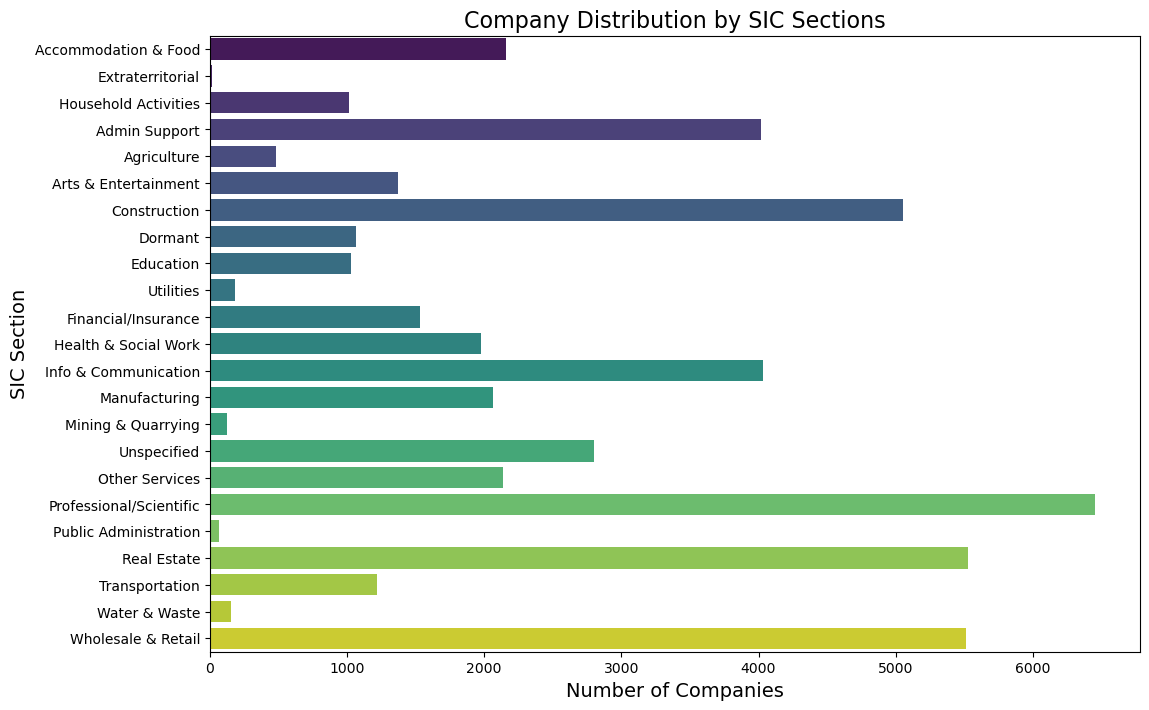

In [47]:
# Frequency counts for simplified SIC sections
sic_counts = final_data_mode_imputed['sic_section_short'].value_counts()

# Bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=sic_counts.values, y=sic_counts.index, palette='viridis')
plt.title('Company Distribution by SIC Sections', fontsize=16)
plt.xlabel('Number of Companies', fontsize=14)
plt.ylabel('SIC Section', fontsize=14)
plt.grid(False)
plt.show()

# Stacked Bar Chart for Overdue Accounts by SIC

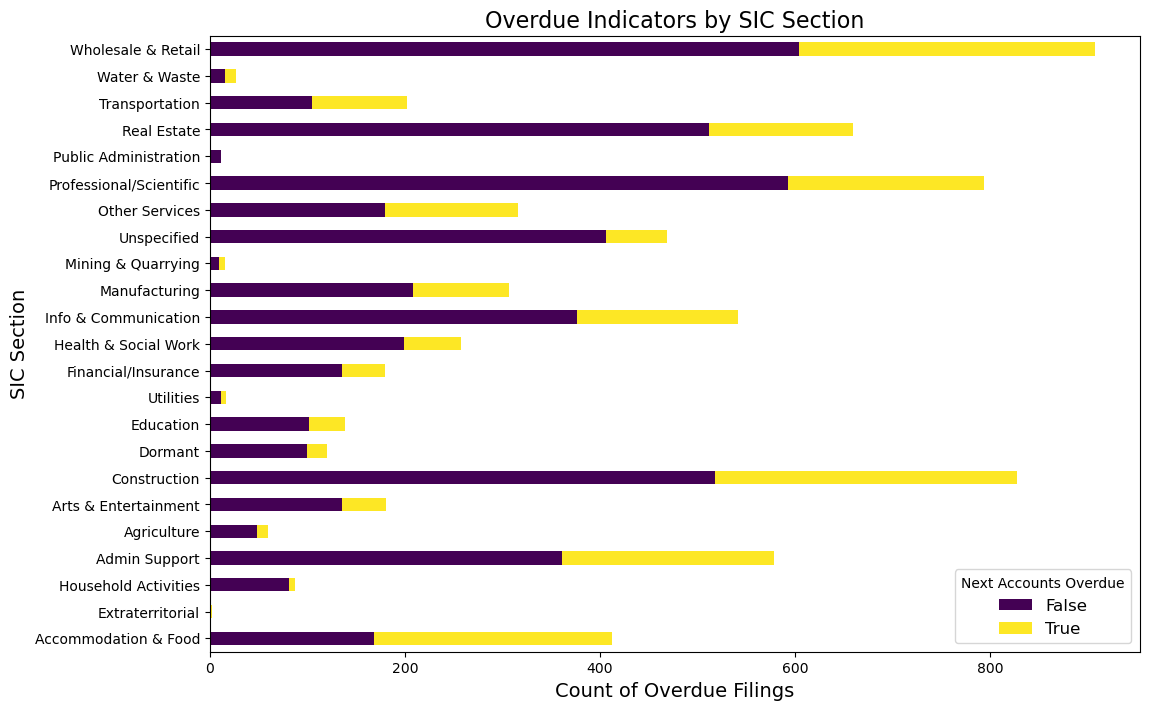

In [49]:
# Cross-tabulation with simplified SIC sections
sic_overdue_ct = pd.crosstab(final_data_mode_imputed['sic_section_short'], final_data['next_accounts_overdue'])

# Plot
sic_overdue_ct.plot(kind='barh', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Overdue Indicators by SIC Section', fontsize=16)
plt.ylabel('SIC Section', fontsize=14)
plt.xlabel('Count of Overdue Filings', fontsize=14)
plt.xticks()
plt.legend(title='Next Accounts Overdue', fontsize=12)
plt.show()

# Correlation Matrix

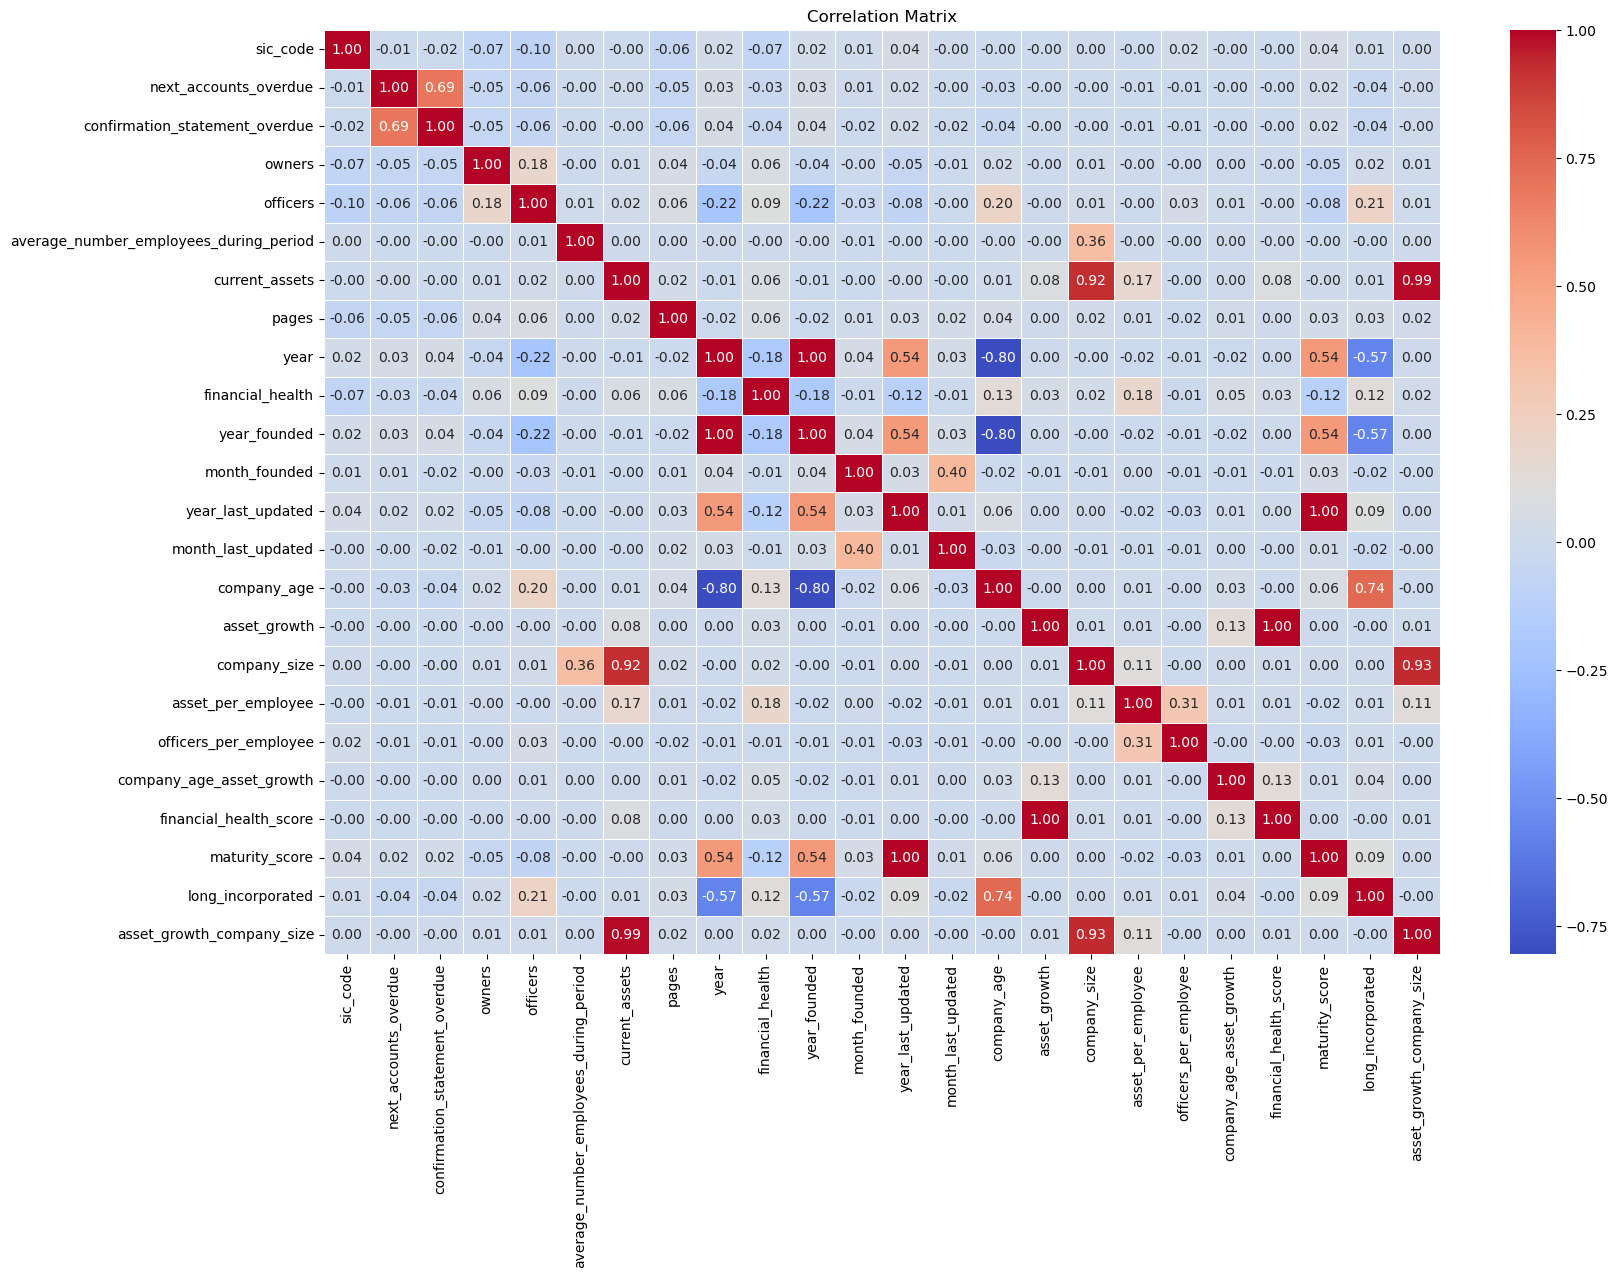

In [51]:
cor_numerical_features= final_data_mode_imputed.select_dtypes(include=['float32', 'float64','int32','int64']).columns
correlation_matrix = final_data_mode_imputed[cor_numerical_features].corr()
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Identify High-Risk Industries

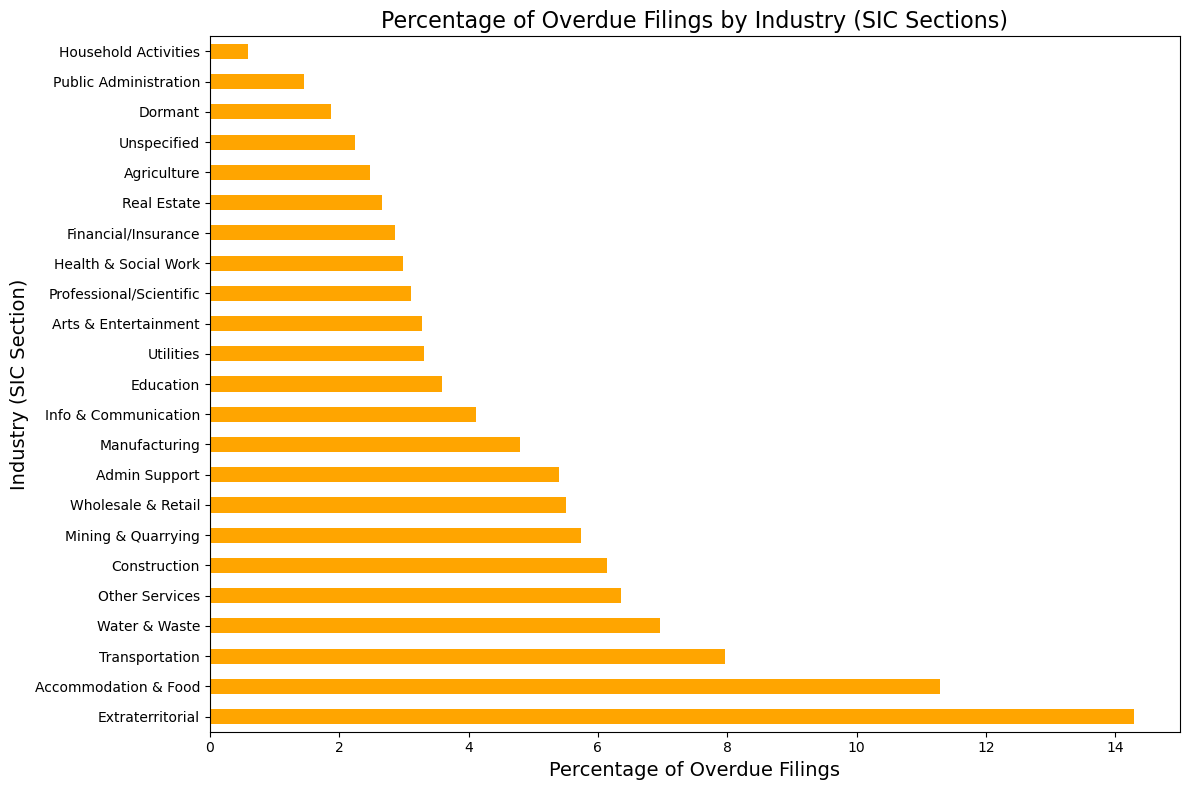

In [53]:
# Calculate percentage of overdue filings for each industry
sic_overdue_percentage = final_data_mode_imputed.groupby('sic_section_short')['next_accounts_overdue'].apply(lambda x: (x == 1).mean() * 100)

# Plot
sic_overdue_percentage.sort_values(ascending=False).plot(kind='barh', color='orange', figsize=(12, 8))
plt.title('Percentage of Overdue Filings by Industry (SIC Sections)', fontsize=16)
plt.xlabel('Percentage of Overdue Filings', fontsize=14)
plt.ylabel('Industry (SIC Section)', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()

# Distrbution of target Variable

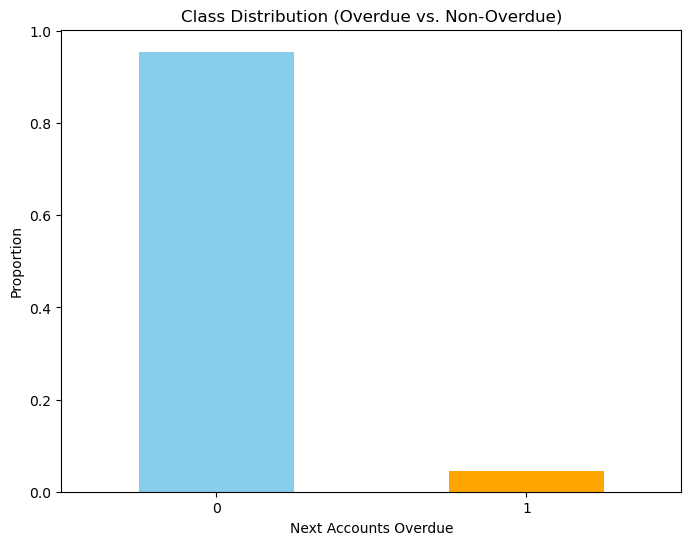

In [55]:
# Distribution of the target variable
target_distribution = final_data_mode_imputed['next_accounts_overdue'].value_counts(normalize=True)
#print(target_distribution)

# plot
plt.figure(figsize=(8, 6))
target_distribution.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Class Distribution (Overdue vs. Non-Overdue)')
plt.xlabel('Next Accounts Overdue')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

In [56]:
# Preprocessing for features (Scaling and Encoding)
numerical_features = [
    'pages', 'owners', 'officers', 'average_number_employees_during_period', 'current_assets',
    'company_age', 'asset_growth','company_size', 'asset_per_employee', 'officers_per_employee', 'company_age_asset_growth', 
    'financial_health_score', 'maturity_score', 'asset_growth_company_size'
]

categorical_features = [
    'category', 'jurisdiction', 'company_status', 
    'account_type', 'industry_company_type', 'industry_company_type_interaction'
]

# Preprocessing pipeline for numerical and categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Use most frequent for categorical columns
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical columns
])

# Numerical transformer (impute missing and scale)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Use median for numerical columns
    ('scaler', StandardScaler())  # Scale numerical data
])

# Apply transformations to the respective columns using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [57]:
# Define features (X) and target (y)
X_mode = final_data_mode_imputed[categorical_features + numerical_features] # Features (X)
y_mode = final_data_mode_imputed['next_accounts_overdue']  # Target variable (y)  # 1 if overdue, 0 if not overdue

In [58]:
# Apply preprocessing pipeline to the data
X_processed_mode = preprocessor.fit_transform(X_mode)

In [59]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_processed_mode, y_mode, test_size=0.2, random_state=12)

In [61]:
final_data_mode_imputed.head()

,sic_code,incorporation_date,jurisdiction,company_status,account_type,next_accounts_overdue,confirmation_statement_overdue,owners,officers,average_number_employees_during_period,...,sic_section_short,industry_company_type,industry_company_type_interaction,asset_per_employee,officers_per_employee,company_age_asset_growth,financial_health_score,maturity_score,long_incorporated,asset_growth_company_size
0,68209.0,1877-05-16,England/Wales,Active,Micro Entity,0,0,1.000000,5.0,4.00000,...,Real Estate,[68209]_Private limited company,Real Estate_Private limited company,1918.500000,1.250000,0.000000,0.463585,NaN,0,0.000000e+00
1,77341.0,1889-05-08,Scotland,Active,Full,0,0,1.000000,9.0,25.23526,...,Admin Support,"[50100, 52220, 77341]_Private limited company",Admin Support_Private limited company,18370.520766,0.356644,7782.685059,59.873394,2020.0,1,6.950166e+08
2,96030.0,1890-05-06,England/Wales,Active,Small,0,0,1.387972,4.0,12.00000,...,Other Services,[96030]_Private limited company,Other Services_Private limited company,38632.072041,0.333333,0.000000,0.463585,2020.0,1,0.000000e+00
3,94110.0,1893-04-28,Scotland,Active,Total Exemption Full,0,0,1.387972,10.0,20.00000,...,Other Services,[94110]_Private limited by guarantee without s...,Other Services_Private limited by guarantee wi...,17380.900000,0.500000,-32.519814,0.097466,2023.0,1,-1.739150e+06
4,74990.0,1895-03-27,Scotland,Dissolved,Filing Exemption Subsidiary,0,0,2.000000,3.0,25.23526,...,Professional/Scientific,[74990]_Private limited company,Professional/Scientific_Private limited company,18370.520766,0.118881,41.366936,0.797189,2019.0,1,3.902732e+06


## Applying smote to reduce the class imbalance

In [63]:
# Apply SMOTE to handle class imbalance
smote_mode = SMOTE(sampling_strategy='auto', random_state=12)  # 'auto' will balance the classes
X_train_mode, y_train_mode = smote_mode.fit_resample(X_train, y_train)

In [64]:
# Check the distribution of the target after applying SMOTE
print(f"Before SMOTE - Class distribution in y_train: \n{y_train.value_counts()}")
print(f"After SMOTE - Class distribution in y_train: \n{y_train_mode.value_counts()}")

Before SMOTE - Class distribution in y_train: 
0    38207
1     1793
Name: next_accounts_overdue, dtype: int64
After SMOTE - Class distribution in y_train: 
0    38207
1    38207
Name: next_accounts_overdue, dtype: int64


## Logistic Regression

In [66]:
# Logistic Regression Model (Mode Imputation)
logreg_model_mode_imputed = LogisticRegression(class_weight='balanced', random_state=12, max_iter=1000)  

logreg_model_mode_imputed.fit(X_train_mode, y_train_mode)
logreg_y_pred_mode_imputed = logreg_model_mode_imputed.predict(X_test)

# Evaluate Logistic Regression model
print("Logistic Regression Classification Report (Mode Imputation):")
print(classification_report(y_test, logreg_y_pred_mode_imputed))
print("Logistic Regression Confusion Matrix (Mode Imputation):")
print(confusion_matrix(y_test, logreg_y_pred_mode_imputed))

Logistic Regression Classification Report (Mode Imputation):
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      9559
           1       0.21      0.59      0.31       441

    accuracy                           0.88     10000
   macro avg       0.59      0.74      0.62     10000
weighted avg       0.95      0.88      0.91     10000

Logistic Regression Confusion Matrix (Mode Imputation):
[[8566  993]
 [ 180  261]]


## Random Forest

In [68]:
# Random Forest Model (Mode Imputation)
rf_model_mode_imputed = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=12)
rf_model_mode_imputed.fit(X_train_mode, y_train_mode)
rf_y_pred_mode_imputed = rf_model_mode_imputed.predict(X_test)

# Evaluate Random Forest model
print("Random Forest Classification Report (Mode Imputation):")
print(classification_report(y_test, rf_y_pred_mode_imputed))
print("Random Forest Confusion Matrix (Mode Imputation):")
print(confusion_matrix(y_test, rf_y_pred_mode_imputed))

Random Forest Classification Report (Mode Imputation):
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      9559
           1       0.21      0.59      0.31       441

    accuracy                           0.89     10000
   macro avg       0.60      0.74      0.63     10000
weighted avg       0.95      0.89      0.91     10000

Random Forest Confusion Matrix (Mode Imputation):
[[8602  957]
 [ 182  259]]


In [69]:
# Check feature importance from the trained model (Random Forest)
importances_mode_imputed = rf_model_mode_imputed.feature_importances_
encoded_columns = numerical_features + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_features))

# Create a DataFrame with feature importances
mode_feature_importance_df = pd.DataFrame({
    'feature': encoded_columns,
    'importance': importances_mode_imputed
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(mode_feature_importance_df.head())


Feature Importance:
                       feature  importance
0                        pages    0.080435
14           category_accounts    0.065734
45  company_status_Liquidation    0.052953
24            category_gazette    0.046106
2                     officers    0.039743


## XGBoost

In [71]:
# XGBoost Model (Mode Imputation)
xgb_model_mode_imputed = XGBClassifier(random_state=12, enable_categorical=True, scale_pos_weight=len(y_train) / (len(y_train) - sum(y_train == 1)))
xgb_model_mode_imputed.fit(X_train_mode, y_train_mode)
xgb_y_pred_mode_imputed = xgb_model_mode_imputed.predict(X_test)

# Evaluate XGBoost model
print("XGBoost Classification Report (Mode Imputation):")
print(classification_report(y_test, xgb_y_pred_mode_imputed))
print("XGBoost Confusion Matrix (Mode Imputation):")
print(confusion_matrix(y_test, xgb_y_pred_mode_imputed))

XGBoost Classification Report (Mode Imputation):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9559
           1       0.92      0.81      0.86       441

    accuracy                           0.99     10000
   macro avg       0.95      0.90      0.93     10000
weighted avg       0.99      0.99      0.99     10000

XGBoost Confusion Matrix (Mode Imputation):
[[9527   32]
 [  85  356]]


## LightGBM

In [73]:
# LightGBM
lgb_model_mode = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
lgb_model_mode.fit(X_train_mode, y_train_mode)
lgb_y_pred_mode = lgb_model_mode.predict(X_test)
lgb_classification_report_mode = classification_report(y_test, lgb_y_pred_mode)
lgb_confusion_matrix_mode = confusion_matrix(y_test, lgb_y_pred_mode)

print("LightGBM Classification Report (Mode Imputation):")
print(lgb_classification_report_mode)
print("LightGBM Confusion Matrix (Mode Imputation):")
print(lgb_confusion_matrix_mode)

[LightGBM] [Info] Number of positive: 38207, number of negative: 38207
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36417
[LightGBM] [Info] Number of data points in the train set: 76414, number of used features: 880
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Classification Report (Mode Imputation):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9559
           1       0.90      0.83      0.86       441

    accuracy                           0.99     10000
   macro avg       0.94      0.92      0.93     10000
weighted avg       0.99      0.99      0.99     10000

LightGBM Confusion Matrix (Mode Imputation):
[[9517   42]
 [  73  368]]


## CatBoost

In [75]:
categorical_columns = final_data_mode_imputed.select_dtypes(include=['object', 'category']).columns
for col in categorical_columns:
    final_data_mode_imputed[col].fillna('missing', inplace=True)
    final_data_mode_imputed[col] = final_data_mode_imputed[col].astype(str)  # Ensure the column is of string type

# Define features (X) and target (y)
X_mode = final_data_mode_imputed[categorical_features + numerical_features] # Features (X)
y_mode = final_data_mode_imputed['next_accounts_overdue']  # Target variable (y)  # 1 if overdue, 0 if not overdue

# Apply preprocessing pipeline to the data
X_processed_mode = preprocessor.fit_transform(X_mode)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_processed_mode, y_mode, test_size=0.2, random_state=12)

# Apply SMOTE to handle class imbalance
smote_mode = SMOTE(sampling_strategy='auto', random_state=12)  # 'auto' will balance the classes
X_train_mode, y_train_mode = smote_mode.fit_resample(X_train, y_train)



In [76]:
# CatBoost
cb_model_mode = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_state=42, verbose=100)


cb_model_mode.fit(X_train_mode, y_train_mode)
cb_y_pred_mode = cb_model_mode.predict(X_test)
cb_classification_report_mode = classification_report(y_test, cb_y_pred_mode)
cb_confusion_matrix_mode = confusion_matrix(y_test, cb_y_pred_mode)

print("CatBoost Classification Report (Mode Imputation):")
print(cb_classification_report_mode)
print("CatBoost Confusion Matrix (Mode Imputation):")
print(cb_confusion_matrix_mode)

0:	learn: 0.5403493	total: 84ms	remaining: 1m 23s
100:	learn: 0.0599039	total: 1.96s	remaining: 17.4s
200:	learn: 0.0377613	total: 3.75s	remaining: 14.9s
300:	learn: 0.0310380	total: 5.5s	remaining: 12.8s
400:	learn: 0.0289602	total: 7.16s	remaining: 10.7s
500:	learn: 0.0258724	total: 8.91s	remaining: 8.87s
600:	learn: 0.0234609	total: 10.7s	remaining: 7.08s
700:	learn: 0.0215140	total: 12.4s	remaining: 5.3s
800:	learn: 0.0200330	total: 14.1s	remaining: 3.52s
900:	learn: 0.0187484	total: 15.8s	remaining: 1.74s
999:	learn: 0.0180558	total: 17.5s	remaining: 0us
CatBoost Classification Report (Mode Imputation):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9559
           1       0.91      0.83      0.87       441

    accuracy                           0.99     10000
   macro avg       0.95      0.91      0.93     10000
weighted avg       0.99      0.99      0.99     10000

CatBoost Confusion Matrix (Mode Imputation):
[[9524   35]

# Regression Imputation

In [79]:
# Identify categorical and numerical features
numerical_features = final_data.select_dtypes(include=['int64', 'int32', 'float32',  'float64']).columns
categorical_features = final_data.select_dtypes(include=['object', 'category']).columns
print(numerical_features)
print(categorical_features)

Index(['sic_code', 'owners', 'officers',
       'average_number_employees_during_period', 'current_assets', 'pages',
       'year'],
      dtype='object')
Index(['sic_section', 'company_type', 'jurisdiction', 'company_status',
       'account_type', 'sic_codes', 'next_accounts_overdue',
       'confirmation_statement_overdue', 'category'],
      dtype='object')


In [80]:
# Now check the categories for both columns
print("Categories for 'next_accounts_overdue':", final_data['next_accounts_overdue'].unique())
print("Categories for 'confirmation_statement_overdue':", final_data['confirmation_statement_overdue'].unique())

Categories for 'next_accounts_overdue': [NaN, False, True]
Categories (2, bool): [False, True]
Categories for 'confirmation_statement_overdue': [NaN, False, True]
Categories (2, bool): [False, True]


In [81]:
# Preprocessing for features (Scaling and Encoding)

numerical_features = ['sic_code', 'owners', 'officers', 'average_number_employees_during_period', 'current_assets', 'pages', 'year']
categorical_features = ['sic_section', 'company_type', 'jurisdiction', 'company_status', 'account_type', 'sic_codes', 'category']

# Preprocessing pipeline for numerical and categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Use most frequent for categorical columns
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical columns
])

# Numerical transformer (impute missing and scale)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Use median for numerical columns
    ('scaler', StandardScaler())  # Scale numerical data
])

# Apply transformations to the respective columns using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [82]:
final_data_regression_imputed = final_data.copy()

# Convert datetime columns to numerical values
date_columns = ['incorporation_date', 'last_accounts_period_end']  # Add any other date columns

# Check if the conversion was successful
print(final_data_regression_imputed[date_columns].head())


  incorporation_date last_accounts_period_end
0         1877-05-16               2023-12-31
1         1889-05-08               2000-01-01
2         1890-05-06               2023-08-31
3         1893-04-28               2023-12-31
4         1895-03-27               2000-01-01


In [83]:
final_data_regression_imputed['missing_next_accounts_overdue'] = final_data_regression_imputed['next_accounts_overdue'].isnull().astype(int)

# Separate numerical and categorical columns
numerical_features = ['sic_code', 'owners', 'officers', 'average_number_employees_during_period', 'current_assets', 'pages', 'year']
categorical_features = ['sic_section', 'company_type', 'jurisdiction', 'company_status', 'account_type', 'sic_codes', 'category']

# Split the data into training (non-missing) and testing (missing) sets
train_data = final_data_regression_imputed[final_data_regression_imputed['next_accounts_overdue'].notnull()]
X_train_reg_impute = train_data[numerical_features + categorical_features]  # Use only numerical and categorical features
y_train_reg_impute = train_data['next_accounts_overdue']

print(X_train_reg_impute.shape)

# Proceed only if there are sufficient non-missing data for training
if X_train_reg_impute.shape[0] > 0:
    # Use a pipeline with preprocessing and Linear Regression
    logreg_model_impute = Pipeline(steps=[
        ('preprocessor', preprocessor), 
        ('classifier', LinearRegression()) 
    ])
    
    logreg_model_impute.fit(X_train_reg_impute, y_train_reg_impute)
    
    # Predict the missing values
    X_missing = final_data_regression_imputed[final_data_regression_imputed['next_accounts_overdue'].isnull()]
    X_missing = X_missing.drop(columns=['next_accounts_overdue', 'missing_next_accounts_overdue'])
    
    predicted_values = logreg_model_impute.predict(X_missing)

    # Ensure predictions are in the range of 0 and 1 (use rounding to convert to boolean)
    predicted_values_rounded = predicted_values.round().astype(int)

    # Impute the missing values with the predicted ones
    # Convert the predicted values (0 or 1) back to boolean (True or False) and assign to the missing entries
    final_data_regression_imputed.loc[final_data_regression_imputed['next_accounts_overdue'].isnull(), 'next_accounts_overdue'] = predicted_values_rounded.astype(bool)

else:
    print("Not enough non-missing data to train the model.")


(7114, 14)


In [84]:
# Now check the categories for both columns
print("Categories for 'next_accounts_overdue':", final_data_regression_imputed['next_accounts_overdue'].unique())
print("Categories for 'confirmation_statement_overdue':", final_data_regression_imputed['confirmation_statement_overdue'].unique())

Categories for 'next_accounts_overdue': [False, True]
Categories (2, bool): [False, True]
Categories for 'confirmation_statement_overdue': [NaN, False, True]
Categories (2, bool): [False, True]


In [85]:
print(final_data_regression_imputed['next_accounts_overdue'])

0        False
1        False
2        False
3        False
4        False
         ...  
49995    False
49996    False
49997    False
49998    False
49999    False
Name: next_accounts_overdue, Length: 50000, dtype: category
Categories (2, bool): [False, True]


In [87]:
final_data_regression_imputed.head()

,sic_code,sic_section,company_type,incorporation_date,jurisdiction,company_status,account_type,sic_codes,next_accounts_overdue,confirmation_statement_overdue,owners,officers,average_number_employees_during_period,current_assets,last_accounts_period_end,date_x,category,pages,year,missing_next_accounts_overdue
0,68209.0,Real estate activities,Private limited company,1877-05-16,England/Wales,Active,Micro Entity,[68209],False,NaN,1.000000,5.0,4.00000,7674.00000,2023-12-31,NaT,accounts,3.0,1877.0,1
1,77341.0,Administrative and support service activities,Private limited company,1889-05-08,Scotland,Active,Full,"[50100, 52220, 77341]",False,NaN,1.000000,9.0,25.23526,463584.86449,2000-01-01,2020-11-16,mortgage,4.0,1889.0,1
2,96030.0,Other service activities,Private limited company,1890-05-06,England/Wales,Active,Small,[96030],False,NaN,1.387972,4.0,12.00000,463584.86449,2023-08-31,2020-11-16,accounts,9.0,1890.0,1
3,94110.0,Other service activities,Private limited by guarantee without share cap...,1893-04-28,Scotland,Active,Total Exemption Full,[94110],False,NaN,1.387972,10.0,20.00000,347618.00000,2023-12-31,2023-04-21,officers,2.0,1893.0,1
4,74990.0,"Professional, scientific and technical activities",Private limited company,1895-03-27,Scotland,Dissolved,Filing Exemption Subsidiary,[74990],False,NaN,2.000000,3.0,25.23526,463584.86449,2000-01-01,2019-04-24,accounts,93.0,1895.0,1


In [88]:
# Check the imputed data for any missing values
print(final_data_regression_imputed.isnull().sum())

sic_code                                      0
sic_section                                   0
company_type                                  1
incorporation_date                            0
jurisdiction                                  1
company_status                                1
account_type                                564
sic_codes                                  2804
next_accounts_overdue                         0
confirmation_statement_overdue            42669
owners                                        0
officers                                      0
average_number_employees_during_period        0
current_assets                                0
last_accounts_period_end                      0
date_x                                        1
category                                    108
pages                                         0
year                                          0
missing_next_accounts_overdue                 0
dtype: int64


In [89]:
numerical_columns = final_data_regression_imputed.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns
categorical_columns = final_data_regression_imputed.select_dtypes(include=['object', 'category']).columns

print(numerical_columns,categorical_columns)

# Impute categorical columns with 'most_frequent' (mode)
for column in categorical_columns:
    final_data_regression_imputed[column] = final_data_regression_imputed[column].fillna(final_data_regression_imputed[column].mode()[0])


Index(['sic_code', 'owners', 'officers',
       'average_number_employees_during_period', 'current_assets', 'pages',
       'year', 'missing_next_accounts_overdue'],
      dtype='object') Index(['sic_section', 'company_type', 'jurisdiction', 'company_status',
       'account_type', 'sic_codes', 'next_accounts_overdue',
       'confirmation_statement_overdue', 'category'],
      dtype='object')


In [90]:
final_data_regression_imputed['next_accounts_overdue'] = final_data_regression_imputed['next_accounts_overdue'].astype(int)
final_data_regression_imputed['confirmation_statement_overdue'] = final_data_regression_imputed['confirmation_statement_overdue'].astype(int)

## Feature Engineering

In [92]:
# Calculate the 50th percentile (median) and 75th percentile for `current_assets`
assets_median = final_data_regression_imputed['current_assets'].median()
assets_75th_percentile = final_data_regression_imputed['current_assets'].quantile(0.75)

# Create financial_health target variable based on `current_assets`
# Companies with assets greater than the 75th percentile are considered financially healthy
final_data_regression_imputed['financial_health'] = final_data_regression_imputed['current_assets'].apply(lambda x: 1 if x > assets_75th_percentile else 0)


# Check the first few rows to ensure the target variables are created correctly
print(final_data_regression_imputed[['financial_health']].head())

# Check the distribution of the target variables
print("\nClass distribution for financial health:")
print(final_data_regression_imputed['financial_health'].value_counts())

   financial_health
0                 0
1                 0
2                 0
3                 0
4                 0

Class distribution for financial health:
0    46168
1     3832
Name: financial_health, dtype: int64


In [93]:

# Handle the year and month extraction
final_data_regression_imputed['year_founded'] = pd.to_datetime(final_data_regression_imputed['incorporation_date'], errors='coerce').dt.year
final_data_regression_imputed['month_founded'] = pd.to_datetime(final_data_regression_imputed['incorporation_date'], errors='coerce').dt.month
final_data_regression_imputed['year_last_updated'] = pd.to_datetime(final_data_regression_imputed['date_x'], errors='coerce').dt.year
final_data_regression_imputed['month_last_updated'] = pd.to_datetime(final_data_regression_imputed['date_x'], errors='coerce').dt.month

# Create company age
final_data_regression_imputed['company_age'] = final_data_regression_imputed['year_last_updated'] - final_data_regression_imputed['year_founded']

# Reduce the memory by downcasting the data types
final_data_regression_imputed['company_age'] = final_data_regression_imputed['company_age'].astype('float32')
final_data_regression_imputed['asset_growth'] = final_data_regression_imputed['current_assets'].diff() / final_data_regression_imputed['current_assets'].shift(1)

# Combine company size based on assets and employees
final_data_regression_imputed['company_size'] = final_data_regression_imputed['average_number_employees_during_period'] * final_data_regression_imputed['current_assets']

# Reduce memory usage by converting columns to 'float32' where possible
final_data_regression_imputed['asset_growth'] = final_data_regression_imputed['asset_growth'].astype('float32')
final_data_regression_imputed['company_size'] = final_data_regression_imputed['company_size'].astype('float32')

# You can also explicitly check memory usage after optimization
print(f"Memory usage after optimization: {final_data_regression_imputed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Memory usage after optimization: 20.08 MB


In [94]:
# SIC Section Mapping
sic_mapping = {
    "Other service activities": "Other Services",
    "Information and communication": "Info & Communication",
    "Professional, scientific and technical activities": "Professional/Scientific",
    "Activities of households as employers; undifferentiated goods-and services-producing activities of households for own use": "Household Activities",
    "Real estate activities": "Real Estate",
    "Transportation and storage": "Transportation",
    "Construction": "Construction",
    "Arts, entertainment and recreation": "Arts & Entertainment",
    "Administrative and support service activities": "Admin Support",
    "None Supplied": "Unspecified",
    "Mining and quarrying": "Mining & Quarrying",
    "Manufacturing": "Manufacturing",
    "Accommodation and food service activities": "Accommodation & Food",
    "Agriculture, forestry and fishing": "Agriculture",
    "Wholesale and retail trade; repair of motor vehicles and motorcycles": "Wholesale & Retail",
    "Dormant company": "Dormant",
    "Education": "Education",
    "Financial and insurance activities": "Financial/Insurance",
    "Human health and social work activities": "Health & Social Work",
    "Electricity, gas, steam and air conditioning supply": "Utilities",
    "Water supply; sewerage, waste management and remediation activities": "Water & Waste",
    "Public administration and defence; compulsory social security": "Public Administration",
    "Activities of extraterritorial organisations and bodies": "Extraterritorial"
}

# Apply mapping
final_data_regression_imputed['sic_section_short'] = final_data_regression_imputed['sic_section'].map(sic_mapping)

In [95]:

# Combine SIC Code and Company Type (Industry Type)
final_data_regression_imputed['industry_company_type'] = final_data_regression_imputed['sic_codes'].astype(str) + "_" + final_data_regression_imputed['company_type'].astype(str)

# Add interaction between SIC Section and Company Type (Industry + Company Type)
final_data_regression_imputed['industry_company_type_interaction'] = final_data_regression_imputed['sic_section_short'].astype(str) + "_" + final_data_regression_imputed['company_type'].astype(str)

# Add asset per employee feature (current_assets / average_number_employees_during_period)
# This feature is useful to assess how efficiently companies utilize their assets per employee.
final_data_regression_imputed['asset_per_employee'] = final_data_regression_imputed['current_assets'] / final_data_regression_imputed['average_number_employees_during_period']
final_data_regression_imputed['asset_per_employee'] = final_data_regression_imputed['asset_per_employee'].replace([np.inf, -np.inf], np.nan)  # Handle infinite values
final_data_regression_imputed['asset_per_employee'].fillna(final_data_regression_imputed['asset_per_employee'].median(), inplace=True)  # Fill NaN values

# Add officers per employee feature (officers / average_number_employees_during_period)
# This feature helps us understand the relationship between company size and management structure.
final_data_regression_imputed['officers_per_employee'] = final_data_regression_imputed['officers'] / final_data_regression_imputed['average_number_employees_during_period']
final_data_regression_imputed['officers_per_employee'] = final_data_regression_imputed['officers_per_employee'].replace([np.inf, -np.inf], np.nan)  # Handle infinite values
final_data_regression_imputed['officers_per_employee'].fillna(final_data_regression_imputed['officers_per_employee'].median(), inplace=True)  # Fill NaN values

# Create a new feature based on company age (company_age * asset_growth)
# This gives an insight into how old companies with higher asset growth are performing in terms of their health.
final_data_regression_imputed['company_age_asset_growth'] = final_data_regression_imputed['company_age'] * final_data_regression_imputed['asset_growth']
final_data_regression_imputed['company_age_asset_growth'] = final_data_regression_imputed['company_age_asset_growth'].replace([np.inf, -np.inf], np.nan)  # Handle infinite values
final_data_regression_imputed['company_age_asset_growth'].fillna(final_data_regression_imputed['company_age_asset_growth'].median(), inplace=True)  # Fill NaN values

# Combine year founded and company age to get insights about the company's maturity
final_data_regression_imputed['maturity_score'] = final_data_regression_imputed['year_founded'] + final_data_regression_imputed['company_age']

# Add a feature to indicate whether the company has been incorporated for a long time (greater than 10 years)
final_data_regression_imputed['long_incorporated'] = (final_data_regression_imputed['company_age'] > 10).astype(int)

# Combine asset growth and company size to understand how asset growth affects company size
final_data_regression_imputed['asset_growth_company_size'] = final_data_regression_imputed['asset_growth'] * final_data_regression_imputed['company_size']
final_data_regression_imputed['asset_growth_company_size'] = final_data_regression_imputed['asset_growth_company_size'].replace([np.inf, -np.inf], np.nan)  # Handle infinite values
final_data_regression_imputed['asset_growth_company_size'].fillna(final_data_regression_imputed['asset_growth_company_size'].median(), inplace=True)  # Fill NaN values

# Dropping unimportant features 
final_data_regression_imputed.drop(columns=['sic_codes', 'company_type', 'sic_section'], inplace=True, errors='ignore')

# Check the updated columns
print(final_data_regression_imputed.columns)


Index(['sic_code', 'incorporation_date', 'jurisdiction', 'company_status',
       'account_type', 'next_accounts_overdue',
       'confirmation_statement_overdue', 'owners', 'officers',
       'average_number_employees_during_period', 'current_assets',
       'last_accounts_period_end', 'date_x', 'category', 'pages', 'year',
       'missing_next_accounts_overdue', 'financial_health', 'year_founded',
       'month_founded', 'year_last_updated', 'month_last_updated',
       'company_age', 'asset_growth', 'company_size', 'sic_section_short',
       'industry_company_type', 'industry_company_type_interaction',
       'asset_per_employee', 'officers_per_employee',
       'company_age_asset_growth', 'maturity_score', 'long_incorporated',
       'asset_growth_company_size'],
      dtype='object')


In [96]:
# Check for NaN values
print("Checking for NaN values in merged_data:")
print(final_data_regression_imputed.isnull().sum())

# Check for infinite values (only for numerical columns)
numerical_columns = final_data_regression_imputed.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns
print("Checking for infinite values in numerical columns:")
print(np.isinf(final_data_regression_imputed[numerical_columns]).sum()) 
final_data_regression_imputed.replace([np.inf, -np.inf], np.nan, inplace=True) 

final_data_regression_imputed['asset_growth'].fillna(0, inplace=True) 

# Check if there are any remaining NaN values after handling infinities
print("Checking for NaN values after handling infinite values:")
print(final_data_regression_imputed.isnull().sum())  

Checking for NaN values in merged_data:
sic_code                                  0
incorporation_date                        0
jurisdiction                              0
company_status                            0
account_type                              0
next_accounts_overdue                     0
confirmation_statement_overdue            0
owners                                    0
officers                                  0
average_number_employees_during_period    0
current_assets                            0
last_accounts_period_end                  0
date_x                                    1
category                                  0
pages                                     0
year                                      0
missing_next_accounts_overdue             0
financial_health                          0
year_founded                              0
month_founded                             0
year_last_updated                         1
month_last_updated                  

In [97]:
# Preprocessing for features (Scaling and Encoding)
numerical_features = [
    'pages', 'owners', 'officers', 'average_number_employees_during_period', 'current_assets',
    'company_age', 'asset_growth','company_size', 'asset_per_employee', 'officers_per_employee', 'company_age_asset_growth', 
     'maturity_score', 'asset_growth_company_size'
]

categorical_features = [
    'category', 'jurisdiction', 'company_status', 
    'account_type', 'industry_company_type', 'industry_company_type_interaction'
]

# Preprocessing pipeline for numerical and categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Use most frequent for categorical columns
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical columns
])

# Numerical transformer (impute missing and scale)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Use median for numerical columns
    ('scaler', StandardScaler())  # Scale numerical data
])

# Apply transformations to the respective columns using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [98]:
# Define features (X) and target (y)
X_regression = final_data_regression_imputed[categorical_features + numerical_features] # Features (X)
y_regression = final_data_regression_imputed['next_accounts_overdue']  # Target variable (y)  # 1 if overdue, 0 if not overdue

In [99]:
# Check for NaN values
print("Checking for NaN values in merged_data:")
print(X_regression.isnull().sum())  

# Check for infinite values (only for numerical columns)
numerical_columns = X_regression.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns
print("Checking for infinite values in numerical columns:")
print(np.isinf(X_regression[numerical_columns]).sum())  

# Check for infinite values (only for numerical columns)
categorical_columns = X_regression.select_dtypes(include=['object', 'category']).columns
print("Checking for missing values in categorical columns:")
print(X_regression[categorical_columns].isnull().sum()) 

# Check for empty strings or any invalid categories
print("Checking for empty strings in categorical columns:")
print((X_regression[categorical_columns] == '').sum())  

# Check if there are any remaining NaN values after handling infinities
print("Checking for NaN values after handling infinite values:")
print(X_regression.isnull().sum())  

Checking for NaN values in merged_data:
category                                  0
jurisdiction                              0
company_status                            0
account_type                              0
industry_company_type                     0
industry_company_type_interaction         0
pages                                     0
owners                                    0
officers                                  0
average_number_employees_during_period    0
current_assets                            0
company_age                               1
asset_growth                              0
company_size                              0
asset_per_employee                        0
officers_per_employee                     0
company_age_asset_growth                  0
maturity_score                            1
asset_growth_company_size                 0
dtype: int64
Checking for infinite values in numerical columns:
pages                                     0
owners          

In [101]:
# Apply preprocessing pipeline to the data
X_processed_reg = preprocessor.fit_transform(X_regression)

In [102]:
# Train-Test Split
X_train_reg_smote, X_test_reg, y_train_reg_smote, y_test_reg = train_test_split(X_processed_reg, y_regression, test_size=0.2, random_state=12)

In [103]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to handle class imbalance
smote_reg = SMOTE(sampling_strategy='auto', random_state=12)  # 'auto' will balance the classes
X_train_reg, y_train_reg = smote_reg.fit_resample(X_train_reg_smote, y_train_reg_smote,)

In [104]:
# Check the distribution of the target after applying SMOTE
print(f"Before SMOTE - Class distribution in y_train: \n{y_train_reg_smote.value_counts()}")
print(f"After SMOTE - Class distribution in y_train: \n{y_train_reg.value_counts()}")

Before SMOTE - Class distribution in y_train: 
0    33464
1     6536
Name: next_accounts_overdue, dtype: int64
After SMOTE - Class distribution in y_train: 
0    33464
1    33464
Name: next_accounts_overdue, dtype: int64


In [105]:
print(X_train_reg_smote.shape)
print(y_train_reg.shape)

(40000, 9873)
(66928,)


## Logistic Regression

In [107]:
# Logistic Regression Model
logreg_model_reg = LogisticRegression(class_weight='balanced', random_state=12, max_iter=1000)  

logreg_model_reg.fit(X_train_reg, y_train_reg)

# Predictions and evaluation
logreg_y_pred_reg = logreg_model_reg.predict(X_test_reg)
print("Logistic Regression Classification Report (Regression Imputation):")
print(classification_report(y_test_reg, logreg_y_pred_reg))
print("Logistic Regression Confusion Matrix (Regression Imputation):")
print(confusion_matrix(y_test_reg, logreg_y_pred_reg))

Logistic Regression Classification Report (Regression Imputation):
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      8391
           1       0.77      0.86      0.81      1609

    accuracy                           0.94     10000
   macro avg       0.87      0.91      0.89     10000
weighted avg       0.94      0.94      0.94     10000

Logistic Regression Confusion Matrix (Regression Imputation):
[[7980  411]
 [ 223 1386]]


## Random Forest

In [109]:
# Random Forest Model (Mode Imputation)
rf_model_reg = RandomForestClassifier(random_state=12)  

rf_model_reg.fit(X_train_reg, y_train_reg)

# Predictions and evaluation
rf_y_pred_reg = rf_model_reg.predict(X_test_reg)

# Evaluate Random Forest model
print("Random Forest Classification Report (Regression Imputation):")
print(classification_report(y_test_reg, rf_y_pred_reg))
print("Random Forest Confusion Matrix (Regression Imputation):")
print(confusion_matrix(y_test_reg, rf_y_pred_reg))

Random Forest Classification Report (Regression Imputation):
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      8391
           1       0.88      0.65      0.75      1609

    accuracy                           0.93     10000
   macro avg       0.91      0.82      0.85     10000
weighted avg       0.93      0.93      0.93     10000

Random Forest Confusion Matrix (Regression Imputation):
[[8249  142]
 [ 560 1049]]


In [110]:
# Check feature importance from the trained model (Random Forest)
importances_regression_imputed = rf_model_reg.feature_importances_
encoded_columns = numerical_features + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_features))

# Create a DataFrame with feature importances
regression_feature_importance_df = pd.DataFrame({
    'feature': encoded_columns,
    'importance': importances_regression_imputed
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(regression_feature_importance_df.head())


Feature Importance:
                     feature  importance
39     company_status_Active    0.074854
0                      pages    0.065346
41  company_status_Dissolved    0.056370
2                   officers    0.041758
23          category_gazette    0.041669


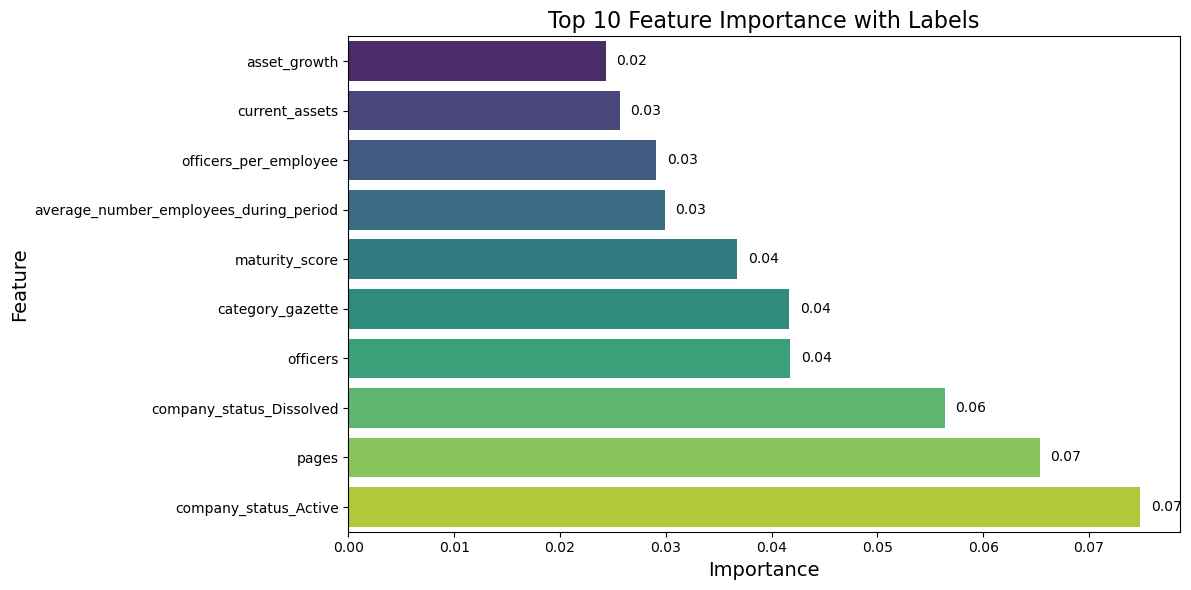

In [111]:
top_features = regression_feature_importance_df.head(10)
top_features_sorted = top_features.sort_values(by='importance', ascending=True)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=top_features_sorted, palette='viridis')
plt.title('Top 10 Feature Importance with Labels', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)

for index, value in enumerate(top_features_sorted['importance']):
    plt.text(value + 0.001, index, f'{value:.2f}', va='center', fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()

## XGBoost

In [113]:
# XGBoost Model
xgb_model_reg = XGBClassifier(random_state=12, enable_categorical=True, scale_pos_weight=len(y_train) / (len(y_train) - sum(y_train == 1)))
xgb_model_reg.fit(X_train_reg, y_train_reg)

# Predictions and evaluation
xgb_y_pred_reg = xgb_model_reg.predict(X_test_reg)

# Evaluate XGBoost model
print("XGBoost Classification Report (Regression Imputation):")
print(classification_report(y_test_reg, xgb_y_pred_reg))
print("XGBoost Confusion Matrix (Regression Imputation):")
print(confusion_matrix(y_test_reg, xgb_y_pred_reg))

XGBoost Classification Report (Regression Imputation):
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      8391
           1       0.85      0.71      0.77      1609

    accuracy                           0.93     10000
   macro avg       0.90      0.84      0.87     10000
weighted avg       0.93      0.93      0.93     10000

XGBoost Confusion Matrix (Regression Imputation):
[[8187  204]
 [ 468 1141]]


## LightGBM

In [115]:
# LightGBM
lgb_model_reg = lgb.LGBMClassifier(random_state=12, class_weight='balanced')
lgb_model_reg.fit(X_train_reg, y_train_reg)

# Predictions and evaluation
lgb_y_pred_reg = lgb_model_reg.predict(X_test_reg)

print("LightGBM Classification Report (Regression Imputation):")
print(classification_report(y_test_reg, lgb_y_pred_reg))
print("LightGBM Confusion Matrix (Regression Imputation):")
print(confusion_matrix(y_test_reg, lgb_y_pred_reg))

[LightGBM] [Info] Number of positive: 33464, number of negative: 33464
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23784
[LightGBM] [Info] Number of data points in the train set: 66928, number of used features: 585
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Classification Report (Regression Imputation):
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      8391
           1       0.85      0.73      0.79      1609

    accuracy                           0.94     10000
   macro avg       0.90      0.85      0.87     10000
weighted avg       0.93      0.94      0.93     10000

LightGBM Confusion Matrix (Regression Imputation):
[[8190  201]
 [ 437 1172]]


## CatBoost

In [117]:
# CatBoost
cb_model_reg = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_state=42, verbose=100)
cb_model_reg.fit(X_train_reg, y_train_reg)

# Predictions and evaluation
cb_y_pred_reg = cb_model_reg.predict(X_test_reg)

print("CatBoost Classification Report (Regression Imputation):")
print(classification_report(y_test_reg, cb_y_pred_reg))
print("CatBoost Confusion Matrix (Regression Imputation):")
print(confusion_matrix(y_test_reg, cb_y_pred_reg))

0:	learn: 0.6124281	total: 21.4ms	remaining: 21.4s
100:	learn: 0.1896022	total: 1.96s	remaining: 17.5s
200:	learn: 0.1578398	total: 3.86s	remaining: 15.3s
300:	learn: 0.1397503	total: 5.71s	remaining: 13.3s
400:	learn: 0.1295577	total: 7.57s	remaining: 11.3s
500:	learn: 0.1231508	total: 9.4s	remaining: 9.36s
600:	learn: 0.1196932	total: 11.2s	remaining: 7.45s
700:	learn: 0.1153363	total: 13.1s	remaining: 5.59s
800:	learn: 0.1113282	total: 14.9s	remaining: 3.71s
900:	learn: 0.1079109	total: 16.8s	remaining: 1.84s
999:	learn: 0.1049568	total: 18.6s	remaining: 0us
CatBoost Classification Report (Regression Imputation):
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      8391
           1       0.86      0.75      0.80      1609

    accuracy                           0.94     10000
   macro avg       0.91      0.86      0.88     10000
weighted avg       0.94      0.94      0.94     10000

CatBoost Confusion Matrix (Regression Imputation)

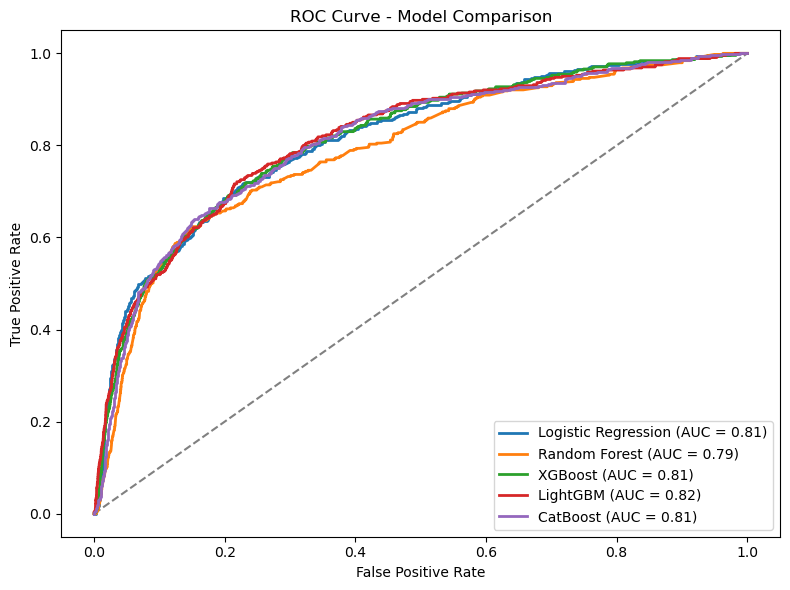

In [385]:
from sklearn.metrics import roc_curve, auc

# Function to plot ROC curve for different models
def plot_roc_curve(y_true, y_pred_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)  # Calculate AUC
    
    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Getting probabilities for each model
rf_y_pred_prob = rf_model_reg.predict_proba(X_test_reg)[:, 1]
lr_y_pred_prob = logreg_model_reg.predict_proba(X_test_reg)[:, 1]
xgb_y_pred_prob = xgb_model_reg.predict_proba(X_test_reg)[:, 1]
lgb_y_pred_prob = lgb_model_reg.predict_proba(X_test_reg)[:, 1]
cb_y_pred_prob = cb_model_reg.predict_proba(X_test_reg)[:, 1]

# Plot ROC curves for all models
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random model)

plot_roc_curve(y_test, lr_y_pred_prob, 'Logistic Regression')
plot_roc_curve(y_test, rf_y_pred_prob, 'Random Forest')
plot_roc_curve(y_test, xgb_y_pred_prob, 'XGBoost')
plot_roc_curve(y_test, lgb_y_pred_prob, 'LightGBM')
plot_roc_curve(y_test, cb_y_pred_prob, 'CatBoost')

# Customizing the plot
plt.title('ROC Curve - Model Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


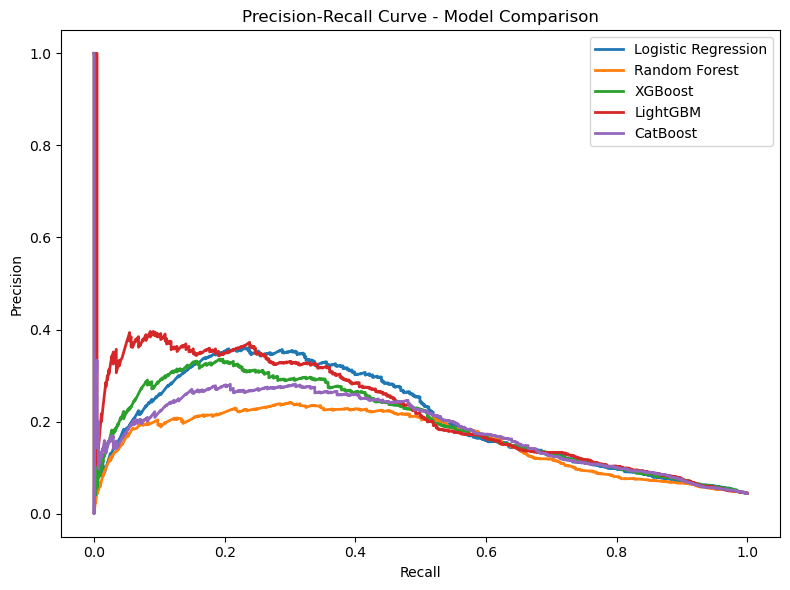

In [387]:
# --- 4.2 Comparing Models using Precision-Recall Curve ---
plt.figure(figsize=(8, 6))
#plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random model)

# Function to plot Precision-Recall curve for each model
def plot_precision_recall_curve(y_true, y_pred_prob, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    plt.plot(recall, precision, lw=2, label=f'{model_name}')

plot_precision_recall_curve(y_test, lr_y_pred_prob, 'Logistic Regression')
plot_precision_recall_curve(y_test, rf_y_pred_prob, 'Random Forest')
plot_precision_recall_curve(y_test, xgb_y_pred_prob, 'XGBoost')
plot_precision_recall_curve(y_test, lgb_y_pred_prob, 'LightGBM')
plot_precision_recall_curve(y_test, cb_y_pred_prob, 'CatBoost')

plt.title('Precision-Recall Curve - Model Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# KNN Imputation

In [121]:
# Identify categorical and numerical features
numerical_features = final_data.select_dtypes(include=['int64', 'int32', 'float32',  'float64']).columns
categorical_features = final_data.select_dtypes(include=['object', 'category']).columns
print(categorical_features)

Index(['sic_section', 'company_type', 'jurisdiction', 'company_status',
       'account_type', 'sic_codes', 'next_accounts_overdue',
       'confirmation_statement_overdue', 'category'],
      dtype='object')


In [123]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder


final_data_knn_imputed = final_data.copy()

# Temporarily convert 'next_accounts_overdue' to numeric (1 for True, 0 for False)
final_data_knn_imputed['next_accounts_overdue'] = final_data_knn_imputed['next_accounts_overdue'].astype('category').cat.codes

# Handle NaN values: Temporarily replace NaN with a placeholder (e.g., -1)
final_data_knn_imputed['next_accounts_overdue'].fillna(-1, inplace=True)

# Apply KNN imputation to impute the missing values
knn_imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors
final_data_knn_imputed_values = knn_imputer.fit_transform(final_data_knn_imputed[['next_accounts_overdue']])

# Convert the imputed values back to a DataFrame
final_data_knn_imputed['next_accounts_overdue'] = final_data_knn_imputed_values

# Round the imputed values to either 0 or 1 (representing False or True)
final_data_knn_imputed['next_accounts_overdue'] = final_data_knn_imputed['next_accounts_overdue'].round().astype(bool)

# Check the distribution of 'next_accounts_overdue' after imputation
print("Distribution of imputed 'next_accounts_overdue':")
print(final_data_knn_imputed['next_accounts_overdue'].value_counts())


Distribution of imputed 'next_accounts_overdue':
True     45120
False     4880
Name: next_accounts_overdue, dtype: int64


In [124]:
print("Distribution of mode 'next_accounts_overdue':")
print(final_data_mode_imputed['next_accounts_overdue'].value_counts())

print("Distribution of regression 'next_accounts_overdue':")
print(final_data_regression_imputed['next_accounts_overdue'].value_counts())

Distribution of mode 'next_accounts_overdue':
0    47766
1     2234
Name: next_accounts_overdue, dtype: int64
Distribution of regression 'next_accounts_overdue':
0    41855
1     8145
Name: next_accounts_overdue, dtype: int64


In [125]:
numerical_columns = final_data_knn_imputed.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns
categorical_columns = final_data_knn_imputed.select_dtypes(include=['object', 'category']).columns

print(numerical_columns,categorical_columns)

# Impute categorical columns with 'most_frequent' (mode)
for column in categorical_columns:
    final_data_knn_imputed[column] = final_data_knn_imputed[column].fillna(final_data_knn_imputed[column].mode()[0])

Index(['sic_code', 'owners', 'officers',
       'average_number_employees_during_period', 'current_assets', 'pages',
       'year'],
      dtype='object') Index(['sic_section', 'company_type', 'jurisdiction', 'company_status',
       'account_type', 'sic_codes', 'confirmation_statement_overdue',
       'category'],
      dtype='object')


In [127]:
# Check the imputed data for any missing values
print(final_data_knn_imputed.isnull().sum())

sic_code                                  0
sic_section                               0
company_type                              0
incorporation_date                        0
jurisdiction                              0
company_status                            0
account_type                              0
sic_codes                                 0
next_accounts_overdue                     0
confirmation_statement_overdue            0
owners                                    0
officers                                  0
average_number_employees_during_period    0
current_assets                            0
last_accounts_period_end                  0
date_x                                    1
category                                  0
pages                                     0
year                                      0
dtype: int64


In [129]:
# Now check the categories for both columns
print("Categories for 'next_accounts_overdue':", final_data_knn_imputed['next_accounts_overdue'].unique())
print("Categories for 'confirmation_statement_overdue':", final_data_knn_imputed['confirmation_statement_overdue'].unique())

Categories for 'next_accounts_overdue': [ True False]
Categories for 'confirmation_statement_overdue': [False, True]
Categories (2, bool): [False, True]


In [130]:
final_data_knn_imputed['next_accounts_overdue'] = final_data_knn_imputed['next_accounts_overdue'].astype(int)
final_data_knn_imputed['confirmation_statement_overdue'] = final_data_knn_imputed['confirmation_statement_overdue'].astype(int)

## Feature Engineering

In [132]:
# Calculate the 50th percentile (median) and 75th percentile for `current_assets`
assets_median = final_data_knn_imputed['current_assets'].median()
assets_75th_percentile = final_data_knn_imputed['current_assets'].quantile(0.75)

# Create financial_health target variable based on `current_assets`
# Companies with assets greater than the 75th percentile are considered financially healthy
final_data_knn_imputed['financial_health'] = final_data_knn_imputed['current_assets'].apply(lambda x: 1 if x > assets_75th_percentile else 0)
print(final_data_knn_imputed[['financial_health']].head())

# Check the distribution of the target variables
print("\nClass distribution for financial health:")
print(final_data_knn_imputed['financial_health'].value_counts())

   financial_health
0                 0
1                 0
2                 0
3                 0
4                 0

Class distribution for financial health:
0    46168
1     3832
Name: financial_health, dtype: int64


In [133]:
# Handle the year and month extraction
final_data_knn_imputed['year_founded'] = pd.to_datetime(final_data_knn_imputed['incorporation_date'], errors='coerce').dt.year
final_data_knn_imputed['month_founded'] = pd.to_datetime(final_data_knn_imputed['incorporation_date'], errors='coerce').dt.month
final_data_knn_imputed['year_last_updated'] = pd.to_datetime(final_data_knn_imputed['date_x'], errors='coerce').dt.year
final_data_knn_imputed['month_last_updated'] = pd.to_datetime(final_data_knn_imputed['date_x'], errors='coerce').dt.month

# Create company age (only works if 'incorporation_date' and 'date_x' are valid)
final_data_knn_imputed['company_age'] = final_data_knn_imputed['year_last_updated'] - final_data_knn_imputed['year_founded']

# Reduce the memory by downcasting the data types
final_data_knn_imputed['company_age'] = final_data_knn_imputed['company_age'].astype('float32')

# Remove pct_change for large datasets to reduce memory usage
final_data_knn_imputed['asset_growth'] = final_data_knn_imputed['current_assets'].diff() / final_data_knn_imputed['current_assets'].shift(1)

# Combine company size based on assets and employees
final_data_knn_imputed['company_size'] = final_data_knn_imputed['average_number_employees_during_period'] * final_data_knn_imputed['current_assets']

# Reduce memory usage by converting columns to 'float32' where possible
final_data_knn_imputed['asset_growth'] = final_data_knn_imputed['asset_growth'].astype('float32')
final_data_knn_imputed['company_size'] = final_data_knn_imputed['company_size'].astype('float32')

print(f"Memory usage after optimization: {final_data_knn_imputed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Memory usage after optimization: 19.70 MB


In [134]:
# SIC Section Mapping
sic_mapping = {
    "Other service activities": "Other Services",
    "Information and communication": "Info & Communication",
    "Professional, scientific and technical activities": "Professional/Scientific",
    "Activities of households as employers; undifferentiated goods-and services-producing activities of households for own use": "Household Activities",
    "Real estate activities": "Real Estate",
    "Transportation and storage": "Transportation",
    "Construction": "Construction",
    "Arts, entertainment and recreation": "Arts & Entertainment",
    "Administrative and support service activities": "Admin Support",
    "None Supplied": "Unspecified",
    "Mining and quarrying": "Mining & Quarrying",
    "Manufacturing": "Manufacturing",
    "Accommodation and food service activities": "Accommodation & Food",
    "Agriculture, forestry and fishing": "Agriculture",
    "Wholesale and retail trade; repair of motor vehicles and motorcycles": "Wholesale & Retail",
    "Dormant company": "Dormant",
    "Education": "Education",
    "Financial and insurance activities": "Financial/Insurance",
    "Human health and social work activities": "Health & Social Work",
    "Electricity, gas, steam and air conditioning supply": "Utilities",
    "Water supply; sewerage, waste management and remediation activities": "Water & Waste",
    "Public administration and defence; compulsory social security": "Public Administration",
    "Activities of extraterritorial organisations and bodies": "Extraterritorial"
}

# Apply mapping
final_data_knn_imputed['sic_section_short'] = final_data_knn_imputed['sic_section'].map(sic_mapping)

In [135]:

# Combine SIC Code and Company Type (Industry Type)
final_data_knn_imputed['industry_company_type'] = final_data_knn_imputed['sic_codes'].astype(str) + "_" + final_data_knn_imputed['company_type'].astype(str)

# Add interaction between SIC Section and Company Type (Industry + Company Type)
final_data_knn_imputed['industry_company_type_interaction'] = final_data_knn_imputed['sic_section_short'].astype(str) + "_" + final_data_knn_imputed['company_type'].astype(str)

# Add asset per employee feature (current_assets / average_number_employees_during_period)
# This feature could be useful to assess how efficiently companies utilize their assets per employee.
final_data_knn_imputed['asset_per_employee'] = final_data_knn_imputed['current_assets'] / final_data_knn_imputed['average_number_employees_during_period']
final_data_knn_imputed['asset_per_employee'] = final_data_knn_imputed['asset_per_employee'].replace([np.inf, -np.inf], np.nan) 
final_data_knn_imputed['asset_per_employee'].fillna(final_data_knn_imputed['asset_per_employee'].median(), inplace=True)  

# Add officers per employee feature (officers / average_number_employees_during_period)
# This feature helps us understand the relationship between company size and management structure.
final_data_knn_imputed['officers_per_employee'] = final_data_knn_imputed['officers'] / final_data_knn_imputed['average_number_employees_during_period']
final_data_knn_imputed['officers_per_employee'] = final_data_knn_imputed['officers_per_employee'].replace([np.inf, -np.inf], np.nan) 
final_data_knn_imputed['officers_per_employee'].fillna(final_data_knn_imputed['officers_per_employee'].median(), inplace=True)  

# Create a new feature based on company age (company_age * asset_growth)
# This gives an insight into how old companies with higher asset growth are performing in terms of their health.
final_data_knn_imputed['company_age_asset_growth'] = final_data_knn_imputed['company_age'] * final_data_knn_imputed['asset_growth']
final_data_knn_imputed['company_age_asset_growth'] = final_data_knn_imputed['company_age_asset_growth'].replace([np.inf, -np.inf], np.nan)  
final_data_knn_imputed['company_age_asset_growth'].fillna(final_data_knn_imputed['company_age_asset_growth'].median(), inplace=True)  

# Combining other features into a new feature: financial health score (based on growth and assets)
# This serve as a simplified measure of financial stability, combining employee growth, asset growth, and current assets.
# Financial health score without employee growth
final_data_knn_imputed['financial_health_score'] = (
final_data_knn_imputed['asset_growth'] +  # Asset growth contribution
    final_data_knn_imputed['current_assets'] / 1_000_000 -  # Scale down current assets
    final_data_knn_imputed['next_accounts_overdue'] * 2  # Penalize overdue accounts
)

# Handle infinite and NaN values
final_data_knn_imputed['financial_health_score'] = final_data_knn_imputed['financial_health_score'].replace([np.inf, -np.inf], np.nan)
final_data_knn_imputed['financial_health_score'].fillna(final_data_knn_imputed['financial_health_score'].median(), inplace=True)

# Combine year founded and company age to get insights about the company's maturity
final_data_knn_imputed['maturity_score'] = final_data_knn_imputed['year_founded'] + final_data_knn_imputed['company_age']

# Add a feature to indicate whether the company has been incorporated for a long time (greater than 10 years)
final_data_knn_imputed['long_incorporated'] = (final_data_knn_imputed['company_age'] > 10).astype(int)

# Combine asset growth and company size to understand how asset growth affects company size
final_data_knn_imputed['asset_growth_company_size'] = final_data_knn_imputed['asset_growth'] * final_data_knn_imputed['company_size']
final_data_knn_imputed['asset_growth_company_size'] = final_data_knn_imputed['asset_growth_company_size'].replace([np.inf, -np.inf], np.nan) 
final_data_knn_imputed['asset_growth_company_size'].fillna(final_data_knn_imputed['asset_growth_company_size'].median(), inplace=True)  

final_data_knn_imputed.drop(columns=['sic_codes', 'company_type', 'sic_section'], inplace=True, errors='ignore')

# Check the updated columns
print(final_data_knn_imputed.columns)


Index(['sic_code', 'incorporation_date', 'jurisdiction', 'company_status',
       'account_type', 'next_accounts_overdue',
       'confirmation_statement_overdue', 'owners', 'officers',
       'average_number_employees_during_period', 'current_assets',
       'last_accounts_period_end', 'date_x', 'category', 'pages', 'year',
       'financial_health', 'year_founded', 'month_founded',
       'year_last_updated', 'month_last_updated', 'company_age',
       'asset_growth', 'company_size', 'sic_section_short',
       'industry_company_type', 'industry_company_type_interaction',
       'asset_per_employee', 'officers_per_employee',
       'company_age_asset_growth', 'financial_health_score', 'maturity_score',
       'long_incorporated', 'asset_growth_company_size'],
      dtype='object')


In [136]:
# Check for NaN values
print("Checking for NaN values in merged_data:")
print(final_data_knn_imputed.isnull().sum())  # Count NaNs in the features

# Check for infinite values (only for numerical columns)
numerical_columns = final_data_knn_imputed.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns
print("Checking for infinite values in numerical columns:")
print(np.isinf(final_data_knn_imputed[numerical_columns]).sum())  

# Handle Infinite Values by replacing with NaN 
final_data_knn_imputed.replace([np.inf, -np.inf], np.nan, inplace=True)  

final_data_knn_imputed['asset_growth'].fillna(0, inplace=True) 

# Check if there are any remaining NaN values after handling infinities
print("Checking for NaN values after handling infinite values:")
print(final_data_knn_imputed.isnull().sum())  # Check if NaNs have been removed

Checking for NaN values in merged_data:
sic_code                                  0
incorporation_date                        0
jurisdiction                              0
company_status                            0
account_type                              0
next_accounts_overdue                     0
confirmation_statement_overdue            0
owners                                    0
officers                                  0
average_number_employees_during_period    0
current_assets                            0
last_accounts_period_end                  0
date_x                                    1
category                                  0
pages                                     0
year                                      0
financial_health                          0
year_founded                              0
month_founded                             0
year_last_updated                         1
month_last_updated                        1
company_age                         

In [137]:
# Preprocessing for features (Scaling and Encoding)
numerical_features = [
    'pages', 'owners', 'officers', 'average_number_employees_during_period', 'current_assets',
    'company_age', 'asset_growth','company_size', 'asset_per_employee', 'officers_per_employee', 'company_age_asset_growth', 
    'financial_health_score', 'maturity_score', 'asset_growth_company_size'
]

categorical_features = [
    'category', 'jurisdiction', 'company_status', 
    'account_type', 'industry_company_type', 'industry_company_type_interaction'
]

# Preprocessing pipeline for numerical and categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Use most frequent for categorical columns
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical columns
])

# Numerical transformer (impute missing and scale)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Use median for numerical columns
    ('scaler', StandardScaler())  # Scale numerical data
])

# Apply transformations to the respective columns using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [138]:
# Define features (X) and target (y)
X_knn = final_data_knn_imputed[categorical_features + numerical_features] # Features (X)
y_knn = final_data_knn_imputed['next_accounts_overdue']  # Target variable (y)  # 1 if overdue, 0 if not overdue

In [139]:
# Apply preprocessing pipeline to the data
X_processed_knn = preprocessor.fit_transform(X_knn)

In [140]:
# Train-Test Split
X_train_knn_smote, X_test_knn, y_train_knn_smote, y_test_knn = train_test_split(X_processed_knn, y_knn, test_size=0.2, random_state=12)

In [141]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to handle class imbalance
smote_knn = SMOTE(sampling_strategy='auto', random_state=12)  # 'auto' will balance the classes
X_train_knn, y_train_knn = smote_reg.fit_resample(X_train_knn_smote, y_train_knn_smote,)

In [142]:
# Step 3: Check the distribution of the target after applying SMOTE
print(f"Before SMOTE - Class distribution in y_train: \n{y_train_knn_smote.value_counts()}")
print(f"After SMOTE - Class distribution in y_train: \n{y_train_knn.value_counts()}")

Before SMOTE - Class distribution in y_train: 
1    36068
0     3932
Name: next_accounts_overdue, dtype: int64
After SMOTE - Class distribution in y_train: 
1    36068
0    36068
Name: next_accounts_overdue, dtype: int64


## Logistic Regression

In [144]:
# Logistic Regression Model
logreg_model_knn = LogisticRegression(class_weight='balanced', random_state=12, max_iter=1000)  

logreg_model_knn.fit(X_train_knn, y_train_knn)

# Predictions and evaluation
logreg_y_pred_knn = logreg_model_knn.predict(X_test_knn)
print("Logistic Regression Classification Report (KNN Imputation):")
print(classification_report(y_test_knn, logreg_y_pred_knn))
print("Logistic Regression Confusion Matrix (KNN Imputation):")
print(confusion_matrix(y_test_knn, logreg_y_pred_knn))

Logistic Regression Classification Report (KNN Imputation):
              precision    recall  f1-score   support

           0       0.16      0.46      0.24       948
           1       0.93      0.74      0.83      9052

    accuracy                           0.72     10000
   macro avg       0.54      0.60      0.53     10000
weighted avg       0.86      0.72      0.77     10000

Logistic Regression Confusion Matrix (KNN Imputation):
[[ 440  508]
 [2323 6729]]


## Random Forest

In [146]:
# Random Forest Model
rf_model_knn = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=12)

rf_model_knn.fit(X_train_knn, y_train_knn)

rf_y_pred_knn = rf_model_knn.predict(X_test_knn)

# Evaluate Random Forest model
print("Random Forest Classification Report (KNN Imputation):")
print(classification_report(y_test_knn, rf_y_pred_knn))
print("Random Forest Confusion Matrix (KNN Imputation):")
print(confusion_matrix(y_test_knn, rf_y_pred_knn))

Random Forest Classification Report (KNN Imputation):
              precision    recall  f1-score   support

           0       0.17      0.43      0.24       948
           1       0.93      0.77      0.84      9052

    accuracy                           0.74     10000
   macro avg       0.55      0.60      0.54     10000
weighted avg       0.86      0.74      0.79     10000

Random Forest Confusion Matrix (KNN Imputation):
[[ 409  539]
 [2059 6993]]


In [147]:
# Check feature importance from the trained model 
importances_knn_imputed = rf_model_knn.feature_importances_
encoded_columns = numerical_features + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_features))

# Create a DataFrame with feature importances
knn_feature_importance_df = pd.DataFrame({
    'feature': encoded_columns,
    'importance': importances_knn_imputed
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(knn_feature_importance_df.head())


Feature Importance:
                                   feature  importance
4                           current_assets    0.078334
60                       account_type_Null    0.072382
42                company_status_Dissolved    0.062819
3   average_number_employees_during_period    0.056042
9                    officers_per_employee    0.041084


## XGBoost

In [149]:
# XGBoost Model
xgb_model_knn = XGBClassifier(random_state=12, enable_categorical=True, scale_pos_weight=len(y_train) / (len(y_train) - sum(y_train == 1)))
xgb_model_knn.fit(X_train_knn, y_train_knn)

xgb_y_pred_knn = xgb_model_knn.predict(X_test_knn)

# Evaluate XGBoost model
print("XGBoost Classification Report (KNN Imputation):")
print(classification_report(y_test_knn, xgb_y_pred_knn))
print("XGBoost Confusion Matrix (KNN Imputation):")
print(confusion_matrix(y_test_knn, xgb_y_pred_knn))

XGBoost Classification Report (KNN Imputation):
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       948
           1       0.98      1.00      0.99      9052

    accuracy                           0.98     10000
   macro avg       0.98      0.90      0.93     10000
weighted avg       0.98      0.98      0.98     10000

XGBoost Confusion Matrix (KNN Imputation):
[[ 758  190]
 [  21 9031]]


## LightGBM

In [151]:
# LightGBM
lgb_model_knn = lgb.LGBMClassifier(random_state=12, class_weight='balanced')
lgb_model_knn.fit(X_train_knn, y_train_knn)

lgb_y_pred_knn = lgb_model_knn.predict(X_test_knn)

print("LightGBM Classification Report (KNN Imputation):")
print(classification_report(y_test_knn, lgb_y_pred_knn))
print("LightGBM Confusion Matrix (KNN Imputation):")
print(confusion_matrix(y_test_knn, lgb_y_pred_knn))

[LightGBM] [Info] Number of positive: 36068, number of negative: 36068
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29193
[LightGBM] [Info] Number of data points in the train set: 72136, number of used features: 787
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Classification Report (KNN Imputation):
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       948
           1       0.98      1.00      0.99      9052

    accuracy                           0.98     10000
   macro avg       0.98      0.92      0.94     10000
weighted avg       0.98      0.98      0.98     10000

LightGBM Confusion Matrix (KNN Imputation):
[[ 793  155]
 [  26 9026]]


## CatBoost

In [153]:
# CatBoost
cb_model_knn = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_state=42, verbose=100)
cb_model_knn.fit(X_train_knn, y_train_knn)
cb_y_pred_knn = cb_model_knn.predict(X_test_knn)

print("CatBoost Classification Report (KNN Imputation):")
print(classification_report(y_test_knn, cb_y_pred_knn))
print("CatBoost Confusion Matrix (KNN Imputation):")
print(confusion_matrix(y_test_knn, cb_y_pred_knn))

0:	learn: 0.5524944	total: 25.2ms	remaining: 25.2s
100:	learn: 0.0923348	total: 1.84s	remaining: 16.4s
200:	learn: 0.0631972	total: 3.56s	remaining: 14.2s
300:	learn: 0.0546957	total: 5.23s	remaining: 12.2s
400:	learn: 0.0483526	total: 6.91s	remaining: 10.3s
500:	learn: 0.0439896	total: 8.66s	remaining: 8.62s
600:	learn: 0.0400323	total: 10.3s	remaining: 6.87s
700:	learn: 0.0377500	total: 12s	remaining: 5.12s
800:	learn: 0.0349279	total: 13.7s	remaining: 3.4s
900:	learn: 0.0327974	total: 15.4s	remaining: 1.69s
999:	learn: 0.0308880	total: 17.1s	remaining: 0us
CatBoost Classification Report (KNN Imputation):
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       948
           1       0.98      1.00      0.99      9052

    accuracy                           0.98     10000
   macro avg       0.97      0.92      0.94     10000
weighted avg       0.98      0.98      0.98     10000

CatBoost Confusion Matrix (KNN Imputation):
[[ 806  142]
 

# Random Forest imputation

In [155]:

# Define the features for numerical and categorical columns
numerical_features = ['sic_code', 'owners', 'officers', 'average_number_employees_during_period', 'current_assets', 'pages', 'year']
categorical_features = ['sic_section', 'company_type', 'jurisdiction', 'company_status', 'account_type', 'sic_codes', 'category']

# Preprocessing pipeline for numerical and categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values using the most frequent category
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical columns
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values using the median
    ('scaler', StandardScaler())  # Scale numerical data to zero mean and unit variance
])

# Apply transformations using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the Random Forest Classifier model (for imputation of 'next_accounts_overdue')
rf_imputer_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocess features using preprocessor
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))  # Use Random Forest for classification
])

# Prepare your data for training
# Replace 'next_accounts_overdue' with a binary numeric column (1 for True, 0 for False)
final_data_rf_imputed = final_data.copy()
final_data_rf_imputed['next_accounts_overdue'] = final_data_rf_imputed['next_accounts_overdue'].map({True: 1, False: 0})

# Separate non-missing and missing data for 'next_accounts_overdue'
train_data = final_data_rf_imputed[final_data_rf_imputed['next_accounts_overdue'].notnull()]
X_train = train_data.drop(columns=['next_accounts_overdue'])
y_train = train_data['next_accounts_overdue']

# Fit the model on non-missing data
rf_imputer_pipeline.fit(X_train, y_train)

# Identify the rows with missing 'next_accounts_overdue' for imputation
X_missing = final_data_rf_imputed[final_data_rf_imputed['next_accounts_overdue'].isnull()].drop(columns=['next_accounts_overdue'])

# Impute the missing values for 'next_accounts_overdue'
predicted_values = rf_imputer_pipeline.predict(X_missing)

# Fill the missing values in the original DataFrame
final_data_rf_imputed.loc[final_data_rf_imputed['next_accounts_overdue'].isnull(), 'next_accounts_overdue'] = predicted_values

# Check the distribution of the imputed 'next_accounts_overdue' column
print("Distribution of imputed 'next_accounts_overdue':")
print(final_data_rf_imputed['next_accounts_overdue'].value_counts())


Distribution of imputed 'next_accounts_overdue':
0    42953
1     7047
Name: next_accounts_overdue, dtype: int64


In [156]:
numerical_columns = final_data_rf_imputed.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns
categorical_columns = final_data_rf_imputed.select_dtypes(include=['object', 'category']).columns

print(numerical_columns,categorical_columns)

# Impute categorical columns with 'most_frequent' (mode)
for column in categorical_columns:
    final_data_rf_imputed[column] = final_data_rf_imputed[column].fillna(final_data_rf_imputed[column].mode()[0])

Index(['sic_code', 'owners', 'officers',
       'average_number_employees_during_period', 'current_assets', 'pages',
       'year'],
      dtype='object') Index(['sic_section', 'company_type', 'jurisdiction', 'company_status',
       'account_type', 'sic_codes', 'next_accounts_overdue',
       'confirmation_statement_overdue', 'category'],
      dtype='object')


In [157]:
final_data_rf_imputed['next_accounts_overdue'] = final_data_rf_imputed['next_accounts_overdue'].astype(int)
final_data_rf_imputed['confirmation_statement_overdue'] = final_data_rf_imputed['confirmation_statement_overdue'].astype(int)

## Feature Engineering

In [159]:
# Calculate the 50th percentile (median) and 75th percentile for `current_assets`
assets_median = final_data_rf_imputed['current_assets'].median()
assets_75th_percentile = final_data_rf_imputed['current_assets'].quantile(0.75)

# Create financial_health target variable based on `current_assets`
# Companies with assets greater than the 75th percentile are considered financially healthy
final_data_rf_imputed['financial_health'] = final_data_rf_imputed['current_assets'].apply(lambda x: 1 if x > assets_75th_percentile else 0)
print(final_data_rf_imputed[['financial_health']].head())

# Check the distribution of the target variables
print("\nClass distribution for financial health:")
print(final_data_rf_imputed['financial_health'].value_counts())

   financial_health
0                 0
1                 0
2                 0
3                 0
4                 0

Class distribution for financial health:
0    46168
1     3832
Name: financial_health, dtype: int64


In [160]:

# Handle the year and month extraction
final_data_rf_imputed['year_founded'] = pd.to_datetime(final_data_rf_imputed['incorporation_date'], errors='coerce').dt.year
final_data_rf_imputed['month_founded'] = pd.to_datetime(final_data_rf_imputed['incorporation_date'], errors='coerce').dt.month
final_data_rf_imputed['year_last_updated'] = pd.to_datetime(final_data_rf_imputed['date_x'], errors='coerce').dt.year
final_data_rf_imputed['month_last_updated'] = pd.to_datetime(final_data_rf_imputed['date_x'], errors='coerce').dt.month

# Create company age (only works if 'incorporation_date' and 'date_x' are valid)
final_data_rf_imputed['company_age'] = final_data_rf_imputed['year_last_updated'] - final_data_rf_imputed['year_founded']

# Reduce the memory by downcasting the data types
final_data_rf_imputed['company_age'] = final_data_rf_imputed['company_age'].astype('float32')

# Remove pct_change for large datasets to reduce memory usage
final_data_rf_imputed['asset_growth'] = final_data_rf_imputed['current_assets'].diff() / final_data_rf_imputed['current_assets'].shift(1)

# Combine company size based on assets and employees
final_data_rf_imputed['company_size'] = final_data_rf_imputed['average_number_employees_during_period'] * final_data_rf_imputed['current_assets']

# Reduce memory usage by converting columns to 'float32' where possible
final_data_rf_imputed['asset_growth'] = final_data_rf_imputed['asset_growth'].astype('float32')
final_data_rf_imputed['company_size'] = final_data_rf_imputed['company_size'].astype('float32')

print(f"Memory usage after optimization: {final_data_rf_imputed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Memory usage after optimization: 19.70 MB


In [161]:
# SIC Section Mapping
sic_mapping = {
    "Other service activities": "Other Services",
    "Information and communication": "Info & Communication",
    "Professional, scientific and technical activities": "Professional/Scientific",
    "Activities of households as employers; undifferentiated goods-and services-producing activities of households for own use": "Household Activities",
    "Real estate activities": "Real Estate",
    "Transportation and storage": "Transportation",
    "Construction": "Construction",
    "Arts, entertainment and recreation": "Arts & Entertainment",
    "Administrative and support service activities": "Admin Support",
    "None Supplied": "Unspecified",
    "Mining and quarrying": "Mining & Quarrying",
    "Manufacturing": "Manufacturing",
    "Accommodation and food service activities": "Accommodation & Food",
    "Agriculture, forestry and fishing": "Agriculture",
    "Wholesale and retail trade; repair of motor vehicles and motorcycles": "Wholesale & Retail",
    "Dormant company": "Dormant",
    "Education": "Education",
    "Financial and insurance activities": "Financial/Insurance",
    "Human health and social work activities": "Health & Social Work",
    "Electricity, gas, steam and air conditioning supply": "Utilities",
    "Water supply; sewerage, waste management and remediation activities": "Water & Waste",
    "Public administration and defence; compulsory social security": "Public Administration",
    "Activities of extraterritorial organisations and bodies": "Extraterritorial"
}

# Apply mapping
final_data_rf_imputed['sic_section_short'] = final_data_rf_imputed['sic_section'].map(sic_mapping)

In [162]:

# Combine SIC Code and Company Type (Industry Type)
final_data_rf_imputed['industry_company_type'] = final_data_rf_imputed['sic_codes'].astype(str) + "_" + final_data_rf_imputed['company_type'].astype(str)

# Add interaction between SIC Section and Company Type (Industry + Company Type)
final_data_rf_imputed['industry_company_type_interaction'] = final_data_rf_imputed['sic_section_short'].astype(str) + "_" + final_data_rf_imputed['company_type'].astype(str)

# Add asset per employee feature (current_assets / average_number_employees_during_period)
# This feature is useful to assess how efficiently companies utilize their assets per employee.
final_data_rf_imputed['asset_per_employee'] = final_data_rf_imputed['current_assets'] / final_data_rf_imputed['average_number_employees_during_period']
final_data_rf_imputed['asset_per_employee'] = final_data_rf_imputed['asset_per_employee'].replace([np.inf, -np.inf], np.nan)  # Handle infinite values
final_data_rf_imputed['asset_per_employee'].fillna(final_data_rf_imputed['asset_per_employee'].median(), inplace=True)  # Fill NaN values

# Add officers per employee feature (officers / average_number_employees_during_period)
# This feature helps us understand the relationship between company size and management structure.
final_data_rf_imputed['officers_per_employee'] = final_data_rf_imputed['officers'] / final_data_rf_imputed['average_number_employees_during_period']
final_data_rf_imputed['officers_per_employee'] = final_data_rf_imputed['officers_per_employee'].replace([np.inf, -np.inf], np.nan)  # Handle infinite values
final_data_rf_imputed['officers_per_employee'].fillna(final_data_rf_imputed['officers_per_employee'].median(), inplace=True)  # Fill NaN values

# Create a new feature based on company age (company_age * asset_growth)
# This can give an insight into how old companies with higher asset growth are performing in terms of their health.
final_data_rf_imputed['company_age_asset_growth'] = final_data_rf_imputed['company_age'] * final_data_rf_imputed['asset_growth']
final_data_rf_imputed['company_age_asset_growth'] = final_data_rf_imputed['company_age_asset_growth'].replace([np.inf, -np.inf], np.nan)  # Handle infinite values
final_data_rf_imputed['company_age_asset_growth'].fillna(final_data_rf_imputed['company_age_asset_growth'].median(), inplace=True)  # Fill NaN values

# Combining other features into a new feature: financial health score (based on growth and assets)
final_data_rf_imputed['financial_health_score'] = (
final_data_rf_imputed['asset_growth'] +  # Asset growth contribution
    final_data_rf_imputed['current_assets'] / 1_000_000 -  # Scale down current assets
    final_data_rf_imputed['next_accounts_overdue'] * 2  # Penalize overdue accounts
)
final_data_rf_imputed['financial_health_score'] = final_data_rf_imputed['financial_health_score'].replace([np.inf, -np.inf], np.nan)
final_data_rf_imputed['financial_health_score'].fillna(final_data_rf_imputed['financial_health_score'].median(), inplace=True)

# Combine year founded and company age to get insights about the company's maturity
final_data_rf_imputed['maturity_score'] = final_data_rf_imputed['year_founded'] + final_data_rf_imputed['company_age']

# Add a feature to indicate whether the company has been incorporated for a long time (greater than 10 years)
final_data_rf_imputed['long_incorporated'] = (final_data_rf_imputed['company_age'] > 10).astype(int)

# Combine asset growth and company size to understand how asset growth affects company size
final_data_rf_imputed['asset_growth_company_size'] = final_data_rf_imputed['asset_growth'] * final_data_rf_imputed['company_size']
final_data_rf_imputed['asset_growth_company_size'] = final_data_rf_imputed['asset_growth_company_size'].replace([np.inf, -np.inf], np.nan)  # Handle infinite values
final_data_rf_imputed['asset_growth_company_size'].fillna(final_data_rf_imputed['asset_growth_company_size'].median(), inplace=True)  # Fill NaN values

# Dropping unimportant features 
final_data_rf_imputed.drop(columns=['sic_codes', 'company_type', 'sic_section'], inplace=True, errors='ignore')

# Check the updated columns
print(final_data_rf_imputed.columns)


Index(['sic_code', 'incorporation_date', 'jurisdiction', 'company_status',
       'account_type', 'next_accounts_overdue',
       'confirmation_statement_overdue', 'owners', 'officers',
       'average_number_employees_during_period', 'current_assets',
       'last_accounts_period_end', 'date_x', 'category', 'pages', 'year',
       'financial_health', 'year_founded', 'month_founded',
       'year_last_updated', 'month_last_updated', 'company_age',
       'asset_growth', 'company_size', 'sic_section_short',
       'industry_company_type', 'industry_company_type_interaction',
       'asset_per_employee', 'officers_per_employee',
       'company_age_asset_growth', 'financial_health_score', 'maturity_score',
       'long_incorporated', 'asset_growth_company_size'],
      dtype='object')


In [163]:
# Check for NaN values
print("Checking for NaN values in merged_data:")
print(final_data_rf_imputed.isnull().sum())  # Count NaNs in the features

# Check for infinite values (only for numerical columns)
numerical_columns = final_data_rf_imputed.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns
print("Checking for infinite values in numerical columns:")
print(np.isinf(final_data_rf_imputed[numerical_columns]).sum())  

# Handle Infinite Values by replacing with NaN (or other strategies)
final_data_rf_imputed.replace([np.inf, -np.inf], np.nan, inplace=True)  

# Handle missing values in 'asset_growth' and 'employee_growth'
final_data_rf_imputed['asset_growth'].fillna(0, inplace=True) 

# Check if there are any remaining NaN values after handling infinities
print("Checking for NaN values after handling infinite values:")
print(final_data_rf_imputed.isnull().sum())  

Checking for NaN values in merged_data:
sic_code                                  0
incorporation_date                        0
jurisdiction                              0
company_status                            0
account_type                              0
next_accounts_overdue                     0
confirmation_statement_overdue            0
owners                                    0
officers                                  0
average_number_employees_during_period    0
current_assets                            0
last_accounts_period_end                  0
date_x                                    1
category                                  0
pages                                     0
year                                      0
financial_health                          0
year_founded                              0
month_founded                             0
year_last_updated                         1
month_last_updated                        1
company_age                         

In [164]:
# Preprocessing for features (Scaling and Encoding)
numerical_features = [
    'pages', 'owners', 'officers', 'average_number_employees_during_period', 'current_assets',
    'company_age', 'asset_growth','company_size', 'asset_per_employee', 'officers_per_employee', 'company_age_asset_growth', 
    'financial_health_score', 'maturity_score', 'asset_growth_company_size'
]

categorical_features = [
    'category', 'jurisdiction', 'company_status', 
    'account_type', 'industry_company_type', 'industry_company_type_interaction'
]

# Preprocessing pipeline for numerical and categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Use most frequent for categorical columns
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical columns
])

# Numerical transformer (impute missing and scale)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Use median for numerical columns
    ('scaler', StandardScaler())  # Scale numerical data
])

# Apply transformations to the respective columns using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [165]:
# Define features (X) and target (y)
X_rf = final_data_rf_imputed[categorical_features + numerical_features] # Features (X)
y_rf = final_data_rf_imputed['next_accounts_overdue']  # Target variable (y)  # 1 if overdue, 0 if not overdue

In [166]:
# Apply preprocessing pipeline to the data
X_processed_rf = preprocessor.fit_transform(X_rf)

In [167]:
# Train-Test Split
X_train_rf_smote, X_test_rf, y_train_rf_smote, y_test_rf = train_test_split(X_processed_rf, y_rf, test_size=0.2, random_state=12)

In [168]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to handle class imbalance
smote_rf = SMOTE(sampling_strategy='auto', random_state=12)  # 'auto' will balance the classes
X_train_rf, y_train_rf = smote_reg.fit_resample(X_train_rf_smote, y_train_rf_smote,)

In [169]:
# Check the distribution of the target after applying SMOTE
print(f"Before SMOTE - Class distribution in y_train: \n{y_train_rf_smote.value_counts()}")
print(f"After SMOTE - Class distribution in y_train: \n{y_train_rf.value_counts()}")

Before SMOTE - Class distribution in y_train: 
0    34366
1     5634
Name: next_accounts_overdue, dtype: int64
After SMOTE - Class distribution in y_train: 
0    34366
1    34366
Name: next_accounts_overdue, dtype: int64


## Logistic Regression

In [171]:
# Logistic Regression Model
logreg_model_rf = LogisticRegression(class_weight='balanced', random_state=12, max_iter=1000)

logreg_model_rf.fit(X_train_rf, y_train_rf)

# Predictions and evaluation
logreg_y_pred_rf = logreg_model_rf.predict(X_test_rf)
print("Logistic Regression Classification Report (Random Forest Imputation):")
print(classification_report(y_test_rf, logreg_y_pred_rf))
print("Logistic Regression Confusion Matrix (Random Forest Imputation):")
print(confusion_matrix(y_test_rf, logreg_y_pred_rf))

Logistic Regression Classification Report (Random Forest Imputation):
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      8587
           1       0.55      0.77      0.64      1413

    accuracy                           0.88     10000
   macro avg       0.76      0.83      0.79     10000
weighted avg       0.90      0.88      0.89     10000

Logistic Regression Confusion Matrix (Random Forest Imputation):
[[7708  879]
 [ 323 1090]]


## Random Forest

In [173]:
# Random Forest Model (Mode Imputation)
rf_model_rf = RandomForestClassifier(n_estimators=50, max_depth=10,random_state=12)  # Classifier (Random Forest)

rf_model_rf.fit(X_train_rf, y_train_rf)
rf_y_pred_rf = rf_model_rf.predict(X_test_rf)

# Evaluate Random Forest model
print("Random Forest Classification Report (Random Forest Imputation):")
print(classification_report(y_test_rf, rf_y_pred_rf))
print("Random Forest Confusion Matrix (Random Forest Imputation):")
print(confusion_matrix(y_test_rf, rf_y_pred_rf))

Random Forest Classification Report (Random Forest Imputation):
              precision    recall  f1-score   support

           0       0.95      0.88      0.92      8587
           1       0.51      0.75      0.61      1413

    accuracy                           0.86     10000
   macro avg       0.73      0.82      0.76     10000
weighted avg       0.89      0.86      0.87     10000

Random Forest Confusion Matrix (Random Forest Imputation):
[[7588  999]
 [ 358 1055]]


In [174]:
# Check feature importance from the trained model (Random Forest)
importances_rf_imputed = rf_model_rf.feature_importances_
encoded_columns = numerical_features + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_features))

# Create a DataFrame with feature importances
rf_feature_importance_df = pd.DataFrame({
    'feature': encoded_columns,
    'importance': importances_rf_imputed
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(rf_feature_importance_df.head())


Feature Importance:
                  feature  importance
40  company_status_Active    0.064752
0                   pages    0.063499
14      category_accounts    0.050296
24       category_gazette    0.044592
2                officers    0.041932


## XGBoost

In [176]:
# XGBoost Model 
xgb_model_rf = XGBClassifier(random_state=12, enable_categorical=True, scale_pos_weight=len(y_train) / (len(y_train) - sum(y_train == 1)))
xgb_model_rf.fit(X_train_rf, y_train_rf)

xgb_y_pred_rf = xgb_model_rf.predict(X_test_rf)

# Evaluate XGBoost model
print("XGBoost Classification Report (Random Forest Imputation):")
print(classification_report(y_test_rf, xgb_y_pred_rf))
print("XGBoost Confusion Matrix (Random Forest Imputation):")
print(confusion_matrix(y_test_rf, xgb_y_pred_rf))

XGBoost Classification Report (Random Forest Imputation):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8587
           1       0.93      0.94      0.94      1413

    accuracy                           0.98     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.98      0.98      0.98     10000

XGBoost Confusion Matrix (Random Forest Imputation):
[[8493   94]
 [  88 1325]]


## LightGBM

In [178]:
# LightGBM
lgb_model_rf = lgb.LGBMClassifier(random_state=12, class_weight='balanced')
lgb_model_rf.fit(X_train_rf, y_train_rf)

lgb_y_pred_rf = lgb_model_rf.predict(X_test_rf)

print("LightGBM Classification Report (Random Forest Imputation):")
print(classification_report(y_test_rf, lgb_y_pred_rf))
print("LightGBM Confusion Matrix (Random Forest Imputation):")
print(confusion_matrix(y_test_rf, lgb_y_pred_rf))

[LightGBM] [Info] Number of positive: 34366, number of negative: 34366
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24047
[LightGBM] [Info] Number of data points in the train set: 68732, number of used features: 529
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Classification Report (Random Forest Imputation):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8587
           1       0.94      0.93      0.93      1413

    accuracy                           0.98     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.98      0.98      0.98     10000

LightGBM Confusion Matrix (Random Forest Imputation):
[[8502   85]
 [  99 1314]]


## CatBoost

In [180]:
# CatBoost
cb_model_rf = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_state=42, verbose=100)
cb_model_rf.fit(X_train_rf, y_train_rf)

cb_y_pred_rf = cb_model_rf.predict(X_test_rf)

print("CatBoost Classification Report (Random Forest Imputation):")
print(classification_report(y_test_rf, cb_y_pred_rf))
print("CatBoost Confusion Matrix (Random Forest Imputation):")
print(confusion_matrix(y_test_rf, cb_y_pred_rf))

0:	learn: 0.5258995	total: 20.3ms	remaining: 20.3s
100:	learn: 0.0748984	total: 1.67s	remaining: 14.8s
200:	learn: 0.0549984	total: 3.23s	remaining: 12.9s
300:	learn: 0.0472668	total: 4.78s	remaining: 11.1s
400:	learn: 0.0429316	total: 6.33s	remaining: 9.45s
500:	learn: 0.0393436	total: 7.86s	remaining: 7.83s
600:	learn: 0.0370225	total: 9.39s	remaining: 6.23s
700:	learn: 0.0347375	total: 10.9s	remaining: 4.66s
800:	learn: 0.0322448	total: 12.5s	remaining: 3.1s
900:	learn: 0.0302430	total: 14s	remaining: 1.54s
999:	learn: 0.0284227	total: 15.6s	remaining: 0us
CatBoost Classification Report (Random Forest Imputation):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8587
           1       0.94      0.92      0.93      1413

    accuracy                           0.98     10000
   macro avg       0.97      0.96      0.96     10000
weighted avg       0.98      0.98      0.98     10000

CatBoost Confusion Matrix (Random Forest Imputat

# Hyper Parameter Training

# L2 Regularization in Logistic Regression

In [183]:
# Train Logistic Regression model with L2 regularization (Ridge)
hpt_logreg_model = LogisticRegression(penalty='l2', random_state=12, max_iter=1000, C=1.0)

hpt_logreg_model.fit(X_train_reg, y_train_reg)
hpt_logreg_y_pred = hpt_logreg_model.predict(X_test_reg)

# Evaluate the model
print("Logistic Regression Classification Report with L2 Regularization")
print(classification_report(y_test_reg, hpt_logreg_y_pred))

Logistic Regression Classification Report with L2 Regularization
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      8391
           1       0.77      0.86      0.81      1609

    accuracy                           0.94     10000
   macro avg       0.87      0.91      0.89     10000
weighted avg       0.94      0.94      0.94     10000



# Random Forest

In [185]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define the parameter grid for RandomForest
param_dist_rf = {
    'n_estimators': [100, 150, 200],  # Number of trees
    'max_depth': [10, 20, None],       # Max depth of the trees
    'min_samples_split': [2, 5, 10],   # Min samples required to split an internal node
    'min_samples_leaf': [1, 2, 3],     # Min samples required to be at a leaf node
    'max_features': ['auto', 'sqrt']  # Max features to consider when splitting
}
# Create RandomizedSearchCV
rf_random_search = RandomizedSearchCV(estimator=rf_model_reg, param_distributions=param_dist_rf, n_iter=10, cv=3, n_jobs=-1, verbose=2, random_state=42, scoring='accuracy')

# Fit the RandomizedSearchCV to the resampled data
rf_random_search.fit(X_train_reg, y_train_reg)

# Get the best parameters found by RandomizedSearchCV
print("Best Parameters for Random Forest:", rf_random_search.best_params_)

# Evaluate the model with the best parameters
best_rf_model = rf_random_search.best_estimator_
rf_hpt_y_test_pred = best_rf_model.predict(X_test_reg)

# Print the classification report
print("Random Forest Hyperparameter Tuning Classification Report:")
print(classification_report(y_test, rf_hpt_y_test_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
Random Forest Hyperparameter Tuning Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      9559
           1       0.17      0.59      0.27       441

    accuracy                           0.86     10000
   macro avg       0.57      0.73      0.59     10000
weighted avg       0.94      0.86      0.89     10000



# XGBoost

In [187]:
from sklearn.model_selection import RandomizedSearchCV

param_dist_xgb = {
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.8, 1.0]
}

random_search_xgb = RandomizedSearchCV(xgb_model_reg, param_dist_xgb, n_iter=7, cv=3, n_jobs=-1, verbose=1, random_state=12)
random_search_xgb.fit(X_train_reg, y_train_reg)

print(f"Best Parameters for XGBoost from RandomizedSearchCV: {random_search_xgb.best_params_}")
print(f"Best Accuracy for XGBoost: {random_search_xgb.best_score_}")


Fitting 3 folds for each of 7 candidates, totalling 21 fits


/Users/shraddha/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:57:53] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "classifier__learning_rate", "classifier__max_depth", "classifier__n_estimators", "classifier__subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/shraddha/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:57:53] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "classifier__learning_rate", "classifier__max_depth", "classifier__n_estimators", "classifier__subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/shraddha/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:57:53] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-spl

Best Parameters for XGBoost from RandomizedSearchCV: {'classifier__subsample': 0.8, 'classifier__n_estimators': 150, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1}
Best Accuracy for XGBoost: 0.9288951192880015


In [188]:
xgb_best = random_search_xgb.best_estimator_
reg_y_pred_xgb = xgb_best.predict(X_test_reg)
print(classification_report(y_test, reg_y_pred_xgb))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      9559
           1       0.18      0.55      0.27       441

    accuracy                           0.87     10000
   macro avg       0.58      0.72      0.60     10000
weighted avg       0.94      0.87      0.90     10000



# LIGHTGBM

In [190]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid_lgb = {
    'classifier__learning_rate': [0.01, 0.05],
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [5, 10],
    'classifier__num_leaves': [31, 40]
}

# Initialize GridSearchCV
grid_search_lgb = GridSearchCV(lgb_model_reg, param_grid_lgb, cv=3, n_jobs=-1, verbose=1, scoring='accuracy')

# Fit the model
grid_search_lgb.fit(X_train_reg, y_train_reg)

# Print the best parameters and score
print(f"Best Parameters for LightGBM: {grid_search_lgb.best_params_}")
print(f"Best Accuracy for LightGBM: {grid_search_lgb.best_score_}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__num_leaves
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__num_leaves
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Info] Number of positive: 33464, number of negative: 33464
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23784
[LightGBM] [Info] Number of data points in the train set: 66928, number of used features: 585
[

In [191]:
# Evaluate on test data
lgb_best = grid_search_lgb.best_estimator_
reg_y_pred_lgb = lgb_best.predict(X_test_reg)
print(classification_report(y_test, reg_y_pred_lgb))

[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__num_leaves
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      9559
           1       0.18      0.55      0.27       441

    accuracy                           0.87     10000
   macro avg       0.58      0.72      0.60     10000
weighted avg       0.94      0.87      0.90     10000



# Catboost

In [193]:
# Define the parameter grid for CatBoost
param_grid_catboost = {
    'iterations': [100, 200],              # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],    # Learning rate
    'depth': [6, 10],                   # Depth of trees
    'l2_leaf_reg': [3, 5],               # L2 regularization
    'border_count': [32, 50]                # Number of splits for numerical features
}

In [194]:
# Perform GridSearchCV with the parameter grid
catboost_grid_search = GridSearchCV(estimator=cb_model_reg, param_grid=param_grid_catboost, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

In [195]:
# Fit the grid search to the training data
catboost_grid_search.fit(X_train_reg, y_train_reg)

# Get the best parameters found by GridSearchCV
print("Best Parameters:", catboost_grid_search.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
0:	learn: 0.6060574	total: 116ms	remaining: 23s
100:	learn: 0.1593807	total: 9.96s	remaining: 9.77s
199:	learn: 0.1286006	total: 20s	remaining: 0us
Best Parameters: {'border_count': 50, 'depth': 10, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.1}


In [196]:
# Evaluate the model with the best parameters
best_catboost_model = catboost_grid_search.best_estimator_
catboost_y_test_pred = best_catboost_model.predict(X_test_reg)

# Output the evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(y_test_reg, catboost_y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test_reg, catboost_y_test_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      8391
           1       0.82      0.72      0.76      1609

    accuracy                           0.93     10000
   macro avg       0.88      0.84      0.86     10000
weighted avg       0.93      0.93      0.93     10000

Confusion Matrix:
[[8135  256]
 [ 456 1153]]


[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__num_leaves
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators


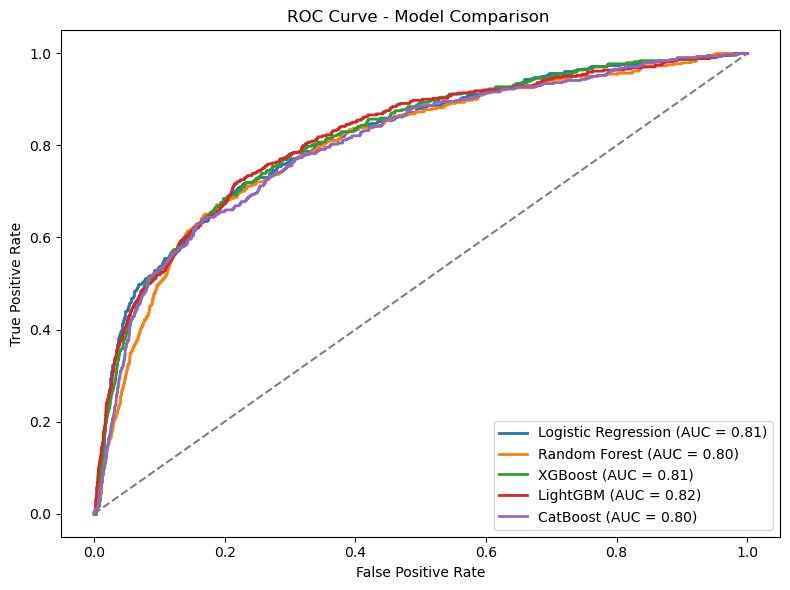

In [197]:
from sklearn.metrics import roc_curve, auc

# Function to plot ROC curve for different models
def plot_roc_curve(y_true, y_pred_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)  # Calculate AUC
    
    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Getting probabilities for each model
hpt_rf_y_pred_prob = best_rf_model.predict_proba(X_test_reg)[:, 1]
hpt_lr_y_pred_prob = hpt_logreg_model.predict_proba(X_test_reg)[:, 1]
hpt_xgb_y_pred_prob = xgb_best.predict_proba(X_test_reg)[:, 1]
hpt_lgb_y_pred_prob = lgb_best.predict_proba(X_test_reg)[:, 1]
hpt_cb_y_pred_prob = best_catboost_model.predict_proba(X_test_reg)[:, 1]

# Plot ROC curves for all models
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random model)

plot_roc_curve(y_test, hpt_lr_y_pred_prob, 'Logistic Regression')
plot_roc_curve(y_test, hpt_rf_y_pred_prob, 'Random Forest')
plot_roc_curve(y_test, hpt_xgb_y_pred_prob, 'XGBoost')
plot_roc_curve(y_test, hpt_lgb_y_pred_prob, 'LightGBM')
plot_roc_curve(y_test, hpt_cb_y_pred_prob, 'CatBoost')

# Customizing the plot
plt.title('ROC Curve - Model Comparison ')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


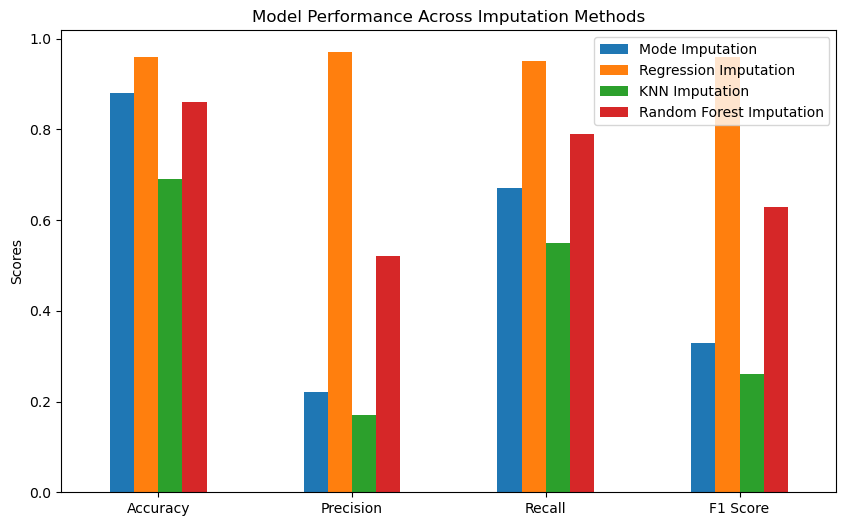

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example of bar plot visualization
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
results = {
    'Mode Imputation': [0.88, 0.22, 0.67, 0.33],
    'Regression Imputation': [0.96, 0.97, 0.95, 0.96],
    'KNN Imputation': [0.69, 0.17, 0.55, 0.26],
    'Random Forest Imputation': [0.86, 0.52, 0.79, 0.63],
}

# Create a DataFrame
import pandas as pd
results_df = pd.DataFrame(results, index=metrics)

# Plot the results
results_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Across Imputation Methods')
plt.ylabel('Scores')
plt.xticks(rotation=0)
plt.show()

# Results for each imputation technique and models

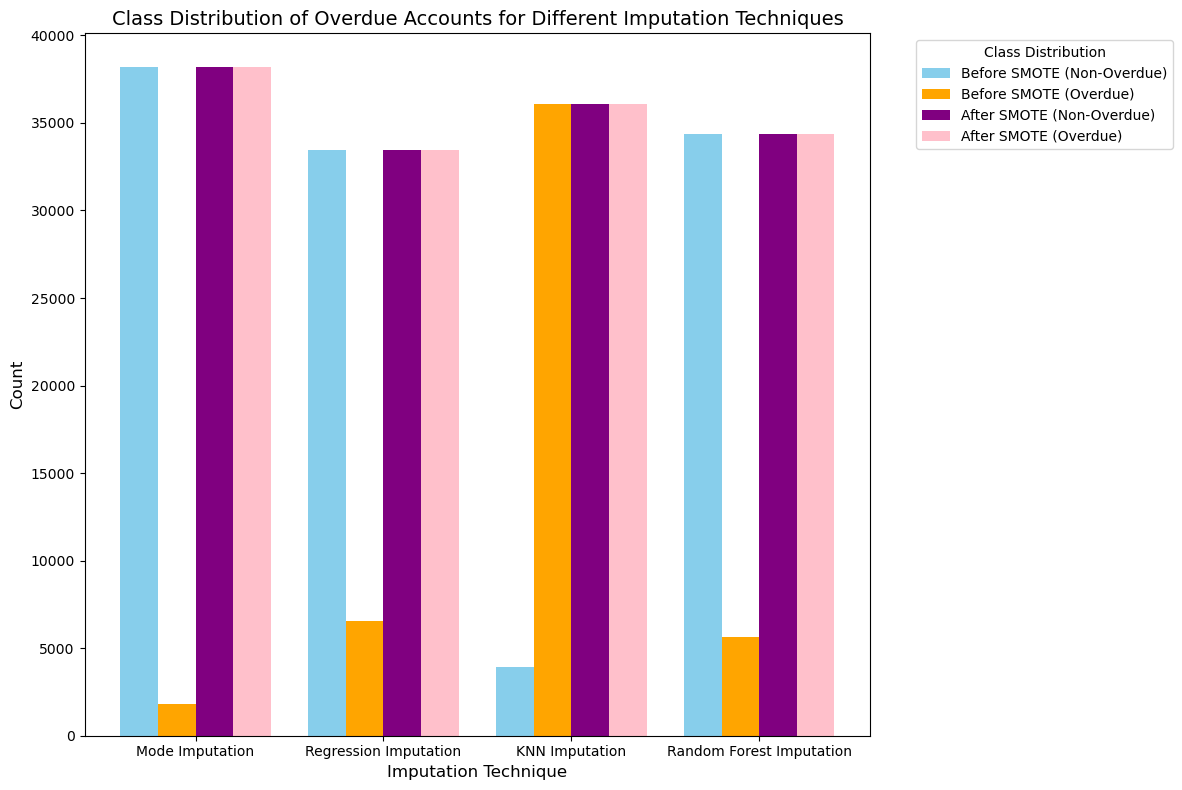

In [202]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the class distributions for each imputation technique
class_distributions_before = {
    'Mode Imputation': [38207, 1793],       # [Non-Overdue, Overdue]
    'Regression Imputation': [33464, 6536],
    'KNN Imputation': [3932, 36068],
    'Random Forest Imputation': [34366, 5634]
}

class_distributions_after = {
    'Mode Imputation': [38207, 38207],
    'Regression Imputation': [33464, 33464],
    'KNN Imputation': [36068, 36068],
    'Random Forest Imputation': [34366, 34366]
}

# Convert to DataFrames for visualization
before_df = pd.DataFrame(class_distributions_before, index=['Non-Overdue', 'Overdue']).T
after_df = pd.DataFrame(class_distributions_after, index=['Non-Overdue', 'Overdue']).T

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 12))  # 2 rows for Before and After

# Before SMOTE
before_df.plot(kind='bar', stacked=True, ax=axes[0], color=['skyblue', 'orange'])
axes[0].set_title('Class Distribution Before SMOTE')
axes[0].set_xlabel('Imputation Technique')
axes[0].set_ylabel('Count')
axes[0].legend(['Non-Overdue', 'Overdue'])
axes[0].tick_params(axis='x', rotation=0)

# After SMOTE
after_df.plot(kind='bar', stacked=True, ax=axes[1], color=['skyblue', 'orange'])
axes[1].set_title('Class Distribution After SMOTE')
axes[1].set_xlabel('Imputation Technique')
axes[1].set_ylabel('Count')
axes[1].legend(['Non-Overdue', 'Overdue'])
axes[1].tick_params(axis='x', rotation=0)

# Adjust layout
plt.tight_layout()
plt.show()


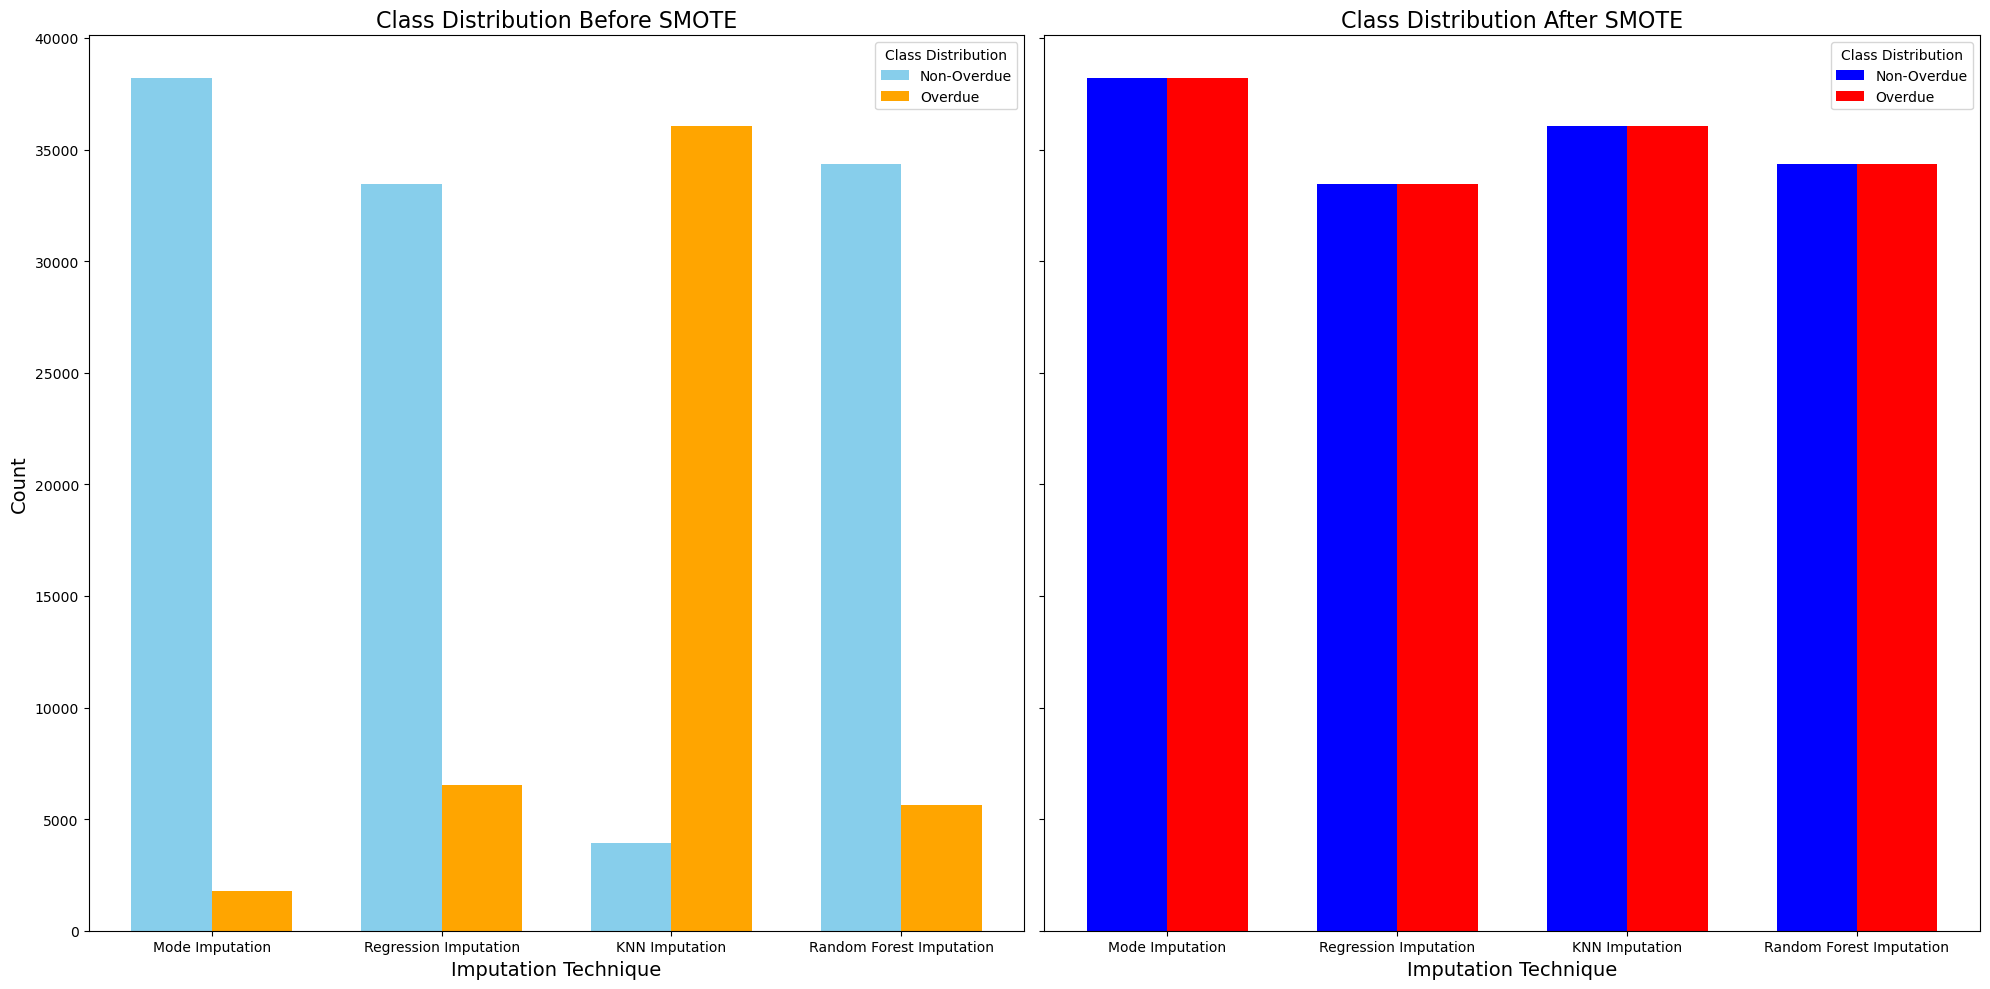

In [204]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Class distributions for each imputation technique
class_distributions = {
    'Imputation Technique': ['Mode Imputation', 'Regression Imputation', 'KNN Imputation', 'Random Forest Imputation'],
    'Before SMOTE (Non-Overdue)': [38207, 33464, 3932, 34366],
    'Before SMOTE (Overdue)': [1793, 6536, 36068, 5634],
    'After SMOTE (Non-Overdue)': [38207, 33464, 36068, 34366],
    'After SMOTE (Overdue)': [38207, 33464, 36068, 34366]
}

# Convert the dictionary into a DataFrame for plotting
df = pd.DataFrame(class_distributions)

# Bar width and positions
bar_width = 0.35
x = np.arange(len(df['Imputation Technique']))  # Positions for bars

# Create a figure with side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

# Plot Before SMOTE
axes[0].bar(x - bar_width / 2, df['Before SMOTE (Non-Overdue)'], width=bar_width, label='Non-Overdue', color='skyblue')
axes[0].bar(x + bar_width / 2, df['Before SMOTE (Overdue)'], width=bar_width, label='Overdue', color='orange')
axes[0].set_title('Class Distribution Before SMOTE', fontsize=16)
axes[0].set_xlabel('Imputation Technique', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(df['Imputation Technique'], rotation=0)
axes[0].legend(title='Class Distribution', loc='upper right')

# Plot After SMOTE
axes[1].bar(x - bar_width / 2, df['After SMOTE (Non-Overdue)'], width=bar_width, label='Non-Overdue', color='blue')
axes[1].bar(x + bar_width / 2, df['After SMOTE (Overdue)'], width=bar_width, label='Overdue', color='red')
axes[1].set_title('Class Distribution After SMOTE', fontsize=16)
axes[1].set_xlabel('Imputation Technique', fontsize=14)
axes[1].set_xticks(x)
axes[1].set_xticklabels(df['Imputation Technique'], rotation=0)
axes[1].legend(title='Class Distribution', loc='upper right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
